<a href="https://colab.research.google.com/github/lj89/CORD19/blob/master/Therapeut_Part_4_Identify_similar_papers_based_on_cosSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identify similar papers based cosine similarity

To test if we can automatically identify similar papers (based on abstracts) from existing ones, I start with universal-sentence-encoder which convert paper abstracts into vectors of size 512. Then I search for the top 5 similar papers with cosine similarity. 
See the example output below. Input dataset generated as method in notebook *Keyword window “polymerase + therapeut" R* and *Part 2 TFIDF Clustering at Abstract level* (a subset of CORD19 data, 1941 “polymerase” related paper abstracts) 


https://www.kaggle.com/leijiang1/part-3-keyword-window-polymerase-therapeut-r

https://www.kaggle.com/leijiang1/part-2-tfidf-clustering-at-abstract-level


For test 2, after manually reading the input, I think the original abstract focus on influenza medicine. My top results are focus on influenza. The reason I chose abstract level analysis is because I think use full body text for topic modeling could have the risk of picking up too much noise. Another point is I chose sentence encoder becasue we'd better not to tokenize medical words (it’s a domain specific property).

#### This method can also be used for a Question Answering system although the performance of which is still subject to evaluation.

I will manually read the output 20 papers for the question "What are clinical effective therapeutics or drugs for COVID-19?" and update.



## Pros and Cons of my method
### So the pros of my method is
My method used Transfer learning of universal-sentence-encoder which means I stand on the shoulder of giant. 🙂 

### cons of my method is 
need to manually read the outputs to validate if the results are solid.


### Universal Sentence Encoder family

There are a number of different Universal Sentence Encoders. I think universal-sentence-encoder-qa should be the best fit for the task of Question Answering.
However, I could not get it to run (ResourceExhaustedError).

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/3") #this step takes long on local, fast on cloud. worked well


embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5") # took some time even on cloud about 1-2 min, got ResourceExhaustedError at next step
The universal-sentence-encoder-large model is trained with a Transformer encoder. try to run on cloud but got got ResourceExhaustedError# 


embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed") #try compressed large, got TypeError: 'AutoTrackable' object is not callable

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-qa/3") # ResourceExhaustedError  




## Major Findings
By Keyword Window search with keywords identified by domain knowledge, I found the following 
### Potential drug candidates:
therapeutic peptides , antiviral nucleosides target rna polyermase; protease inhibitor; monoclonal antibody can be a target; macrocyclic peptides; gs5734; quercetin; pb2 subunit; xinjiaxiangruyin; iav usurps zbtb25; m2 inhibitors; nitazoxanide ntz; active small molecular inhibitors; NHC;… (Based on past researches on sars/mers,flu, hcv,herp, ebov – other diseases caused by rna viruses)


## Conclusion
CORD19 project is about Text Mining, Knowledge Discovery & Question Answer.
Our goal: efficiently extract information from 45,000 + papers to find cures for COVID-19.


My method of identify similar papers based cosine similarity is tested to be effective.

Question Answering system based on the same method also seem to work, but need further validation. How to design a informative enough question is actually the tricky part.

More research can be done use the top words identified in text mining in combination with domain knowledge. I plan to come back after my final projects to dig deeper.

Also got pretty good document dlustering results. Worth trying to label the clusters. May find useful information.

### Use methods in combination

Furthermore, after finding the most similar papers/abstracts, we can use the Keyword window method described in previous posts to retrieve more detailed information. So these methods can be used in combination to achieve better results.


## Import Libraries

In [0]:
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [0]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import matplotlib
from nltk.tokenize import word_tokenize
from nltk import edit_distance
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
# allow access to google drive files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path = "/content/drive/My Drive/Colab Notebooks/cord19/data/"
data_filename = data_path +"tibbleTherapeut3775.csv"
print(data_filename)

/content/drive/My Drive/Colab Notebooks/cord19/data/tibbleTherapeut3775.csv


## Import Data

In [0]:
import pandas as pd 

df = pd.read_csv(data_filename)  #start with window
df.head(5)

Unnamed: 0  ...                                             WINDOW
0           1  ...  a confirmed teratogen. Understanding host-path...
1           2  ...  is susceptible to allosteric inhibition, which...
2           3  ...  new avenue for the future development of allos...
3           4  ...  ABSTRACTCancer gene therapy is a great promisi...
4           5  ...  elements necessary for infection and pathogene...

[5 rows x 23 columns]

In [0]:
df.shape

(3775, 23)

In [0]:
df.isnull().sum()

Unnamed: 0                        0
cord_uid                          0
sha                             822
source_x                          0
title                             0
doi                              87
pmcid                          1123
pubmed_id                       492
license                           0
abstract                          0
publish_time                      0
authors                           6
journal                         174
Microsoft.Academic.Paper.ID    3723
WHO..Covidence                 3686
has_full_text                     0
full_text_file                  754
url                               9
WORDS                             0
INDEX                             0
WINDOW_START                      0
WINDOW_END                        0
WINDOW                           87
dtype: int64

In [0]:
# dfTitle=df[['title']]
# dfTitle.shape

(3775, 1)

In [0]:
# dfTitle.drop_duplicates(keep='last')  #interested in how manyduplicated title=unique name of papers
# dfTitle.shape

(3775, 1)

In [0]:
df1 = df[['doi','title','abstract','WINDOW']]
df1.head(5)

doi  ...                                             WINDOW
0  10.1101/061788  ...  a confirmed teratogen. Understanding host-path...
1  10.1101/078113  ...  is susceptible to allosteric inhibition, which...
2  10.1101/078543  ...  new avenue for the future development of allos...
3  10.1101/147736  ...  ABSTRACTCancer gene therapy is a great promisi...
4  10.1101/173286  ...  elements necessary for infection and pathogene...

[5 rows x 4 columns]

In [0]:
df1.shape

(3775, 4)

In [0]:
df2=df1.drop_duplicates(keep='last') #ValueError: operands could not be broadcast together with shapes (3775,) (3688,) (3775,) 

In [0]:
df2.shape # after drop dulplicates (3751, 4)

(3751, 4)

In [0]:
df2.abstract.shape

(3751,)

In [0]:
df2.abstract.isnull().sum()

0

In [0]:
# df2.WINDOW.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


In [0]:
# df2.WINDOW.isnull().sum()

0

In [0]:
# df.WINDOW.shape #after dropna (3688,)

(3688,)

In [0]:
df2.abstract.drop_duplicates(keep='last')

0       ABSTRACTZika Virus (ZIKV) is a causative agent...
1       ABSTRACTZika virus can be passed from a pregna...
2       ABSTRACTIt has been recently estimated that on...
3       ABSTRACTCancer gene therapy is a great promisi...
5       AbstractCoronaviruses encode a mix of highly c...
                              ...                        
3768    Abstract Despite remarkable advances in medica...
3769    Abstract Mammalian exchange protein directly a...
3770    Antibody therapeutics are one of the fastest g...
3773    Abstract MicroRNAs (miRNAs) are small non-codi...
3774    Abstract The four mammalian phosphatidylinosit...
Name: abstract, Length: 2829, dtype: object

In [0]:
df2.abstract.shape

(3751,)

In [0]:
outString = ' '.join(df2.abstract) #dropna, drop duplicates
print (outString)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
len(outString ) #6,805,659  # WINDOW 735,294

6805659

## Remove stopwords and apply stemmer on words

In [0]:
def stems(words, method) :
    prtr = nltk.stem.PorterStemmer()
    snob = nltk.stem.SnowballStemmer('english')
    lema = nltk.wordnet.WordNetLemmatizer()
    
    word_to_stem = stopwords_removal(words)

    stem = [w for w in word_to_stem]
    stem = []
    
    if method == 'porter' :
        for w in word_to_stem:
            stem.append(prtr.stem(w))
 
    elif method == 'snowball': 
        for w in word_to_stem:
            stem.append(snob.stem(w))

    return (stem)

In [0]:
def stopwords_removal(words) :
    stop_word = set(stopwords.words('english'))
    word_token = word_tokenize(words)
    output_sentence = [words for word in word_token if not word in stop_word]
    output_sentence = []
    for w in word_token:
        if w not in stop_word:
            output_sentence.append(w)
    return(output_sentence)


In [0]:
stopwords_output = stopwords_removal(outString)
for w in stopwords_output:
    print(w+"|",end=' ') #nltk problem, this part cannot run on colab, but can run on kaggle kernel #Resource stopwords not found.

LookupError: ignored

In [0]:
snowball_stems = stems(outString, "snowball")
print("After stemming, there are",len(snowball_stems),"words. And they are as following:")
print()
for s in snowball_stems:
    print(s+"|",end=' ')
    
 #After stemming, there are 290097 words. And they are as following:

LookupError: ignored

In [0]:
import string
x=snowball_stems
x = [''.join(c for c in s if c not in string.punctuation) for s in x]
x

['abstract',
 'astrocyt',
 'produc',
 'granulocytemacrophag',
 'colonystimul',
 'factor',
 'gmcsf',
 'support',
 'surviv',
 'prolifer',
 'microglia',
 'studi',
 'function',
 'gmcsf',
 'central',
 'nervous',
 'system',
 'cns',
 'examin',
 'effect',
 'gmcsf',
 'cytokin',
 'product',
 'glial',
 'cell',
 'gmcsf',
 'induc',
 'interleukin6',
 'il6',
 'product',
 'microglia',
 'astrocyt',
 'dosedepend',
 'manner',
 'assess',
 'bioassay',
 'detect',
 'il6',
 'mrna',
 'revers',
 'transcriptasepolymeras',
 'chain',
 'reaction',
 'rtpcr',
 'analysi',
 'gmcsf',
 'induc',
 'tumor',
 'necrosi',
 'factor',
 'tnfa',
 'il1',
 'microglia',
 'astrocyt',
 'wherea',
 'lipopolysaccharid',
 'induc',
 'cytokin',
 'induct',
 'il6',
 'gmcsf',
 'microglia',
 'complet',
 'inhibit',
 'antibodi',
 'gmcsf',
 'neither',
 'il3',
 'macrophagecsf',
 'mcsf',
 'induc',
 'il6',
 'product',
 'microglia',
 'given',
 'il1',
 'tnf',
 'monokin',
 'deriv',
 'microglia',
 'induc',
 'il6',
 'product',
 'astrocyt',
 'microglia',
 '

In [0]:
x = [s for s in x if s]
x

['abstract',
 'astrocyt',
 'produc',
 'granulocytemacrophag',
 'colonystimul',
 'factor',
 'gmcsf',
 'support',
 'surviv',
 'prolifer',
 'microglia',
 'studi',
 'function',
 'gmcsf',
 'central',
 'nervous',
 'system',
 'cns',
 'examin',
 'effect',
 'gmcsf',
 'cytokin',
 'product',
 'glial',
 'cell',
 'gmcsf',
 'induc',
 'interleukin6',
 'il6',
 'product',
 'microglia',
 'astrocyt',
 'dosedepend',
 'manner',
 'assess',
 'bioassay',
 'detect',
 'il6',
 'mrna',
 'revers',
 'transcriptasepolymeras',
 'chain',
 'reaction',
 'rtpcr',
 'analysi',
 'gmcsf',
 'induc',
 'tumor',
 'necrosi',
 'factor',
 'tnfa',
 'il1',
 'microglia',
 'astrocyt',
 'wherea',
 'lipopolysaccharid',
 'induc',
 'cytokin',
 'induct',
 'il6',
 'gmcsf',
 'microglia',
 'complet',
 'inhibit',
 'antibodi',
 'gmcsf',
 'neither',
 'il3',
 'macrophagecsf',
 'mcsf',
 'induc',
 'il6',
 'product',
 'microglia',
 'given',
 'il1',
 'tnf',
 'monokin',
 'deriv',
 'microglia',
 'induc',
 'il6',
 'product',
 'astrocyt',
 'microglia',
 '

## EDA - top words

#### Before modeling, I'd like to check what words talked about most in this subset of "Polymerase" papers. We can also identify more keywords for further analysis form the top word list and word cloud.

In [0]:
# from collections import Counter
# import matplotlib.pyplot as plt
# import numpy as np

# import matplotlib

# matplotlib.rcParams['font.sans-serif'] = "Arial"
# matplotlib.rcParams['figure.dpi'] = 300
# barWidth = 0.25
# plt.figure(figsize=(20,15))

# counts = Counter(x)
# common = counts.most_common(50)
# labels = [item[0] for item in common]
# number = [item[1] for item in common]
# nbars = len(common)

# plt.bar(np.arange(nbars), number,width=barWidth, tick_label=labels)
# plt.xticks(rotation = 90, fontweight='bold',fontsize=12,)
# plt.show()

In [0]:
# x can not use on colab
# barWidth = 0.25
# plt.figure(figsize=(20,40))

# counts = Counter(x)
# common = counts.most_common(200)
# labels = [item[0] for item in common]
# number = [item[1] for item in common]
# nbars = len(common)

# plt.barh(np.arange(nbars), number,tick_label=labels) #width=barWidth, 
# plt.xticks( fontweight='bold',fontsize=12,) #rotation = 90,
# plt.title('Top 200 words in titles of ' +str(df.ABS.shape[0])+  ' research papers mentioned Polymerase',fontsize=15)#,fontweight='bold'   #df2.title.shape
# plt.show()

## Customize stop words

In [0]:
customize_stop_words2 = [
    'used', 'using', 'SARS CoV','MERS CoV','Abstract','found','result','method','conclusion','results','case','cases',
    'compared','many','well','including','identified','Although','present','Middle East','infection','patient'
    'infectious','treatment','China','East','Role','COVID','human','model','Chapter','viruses','methods','disease'
]
#capital letter must match

STOPWORDS2 = list(STOPWORDS)  + customize_stop_words2

## Word Cloud

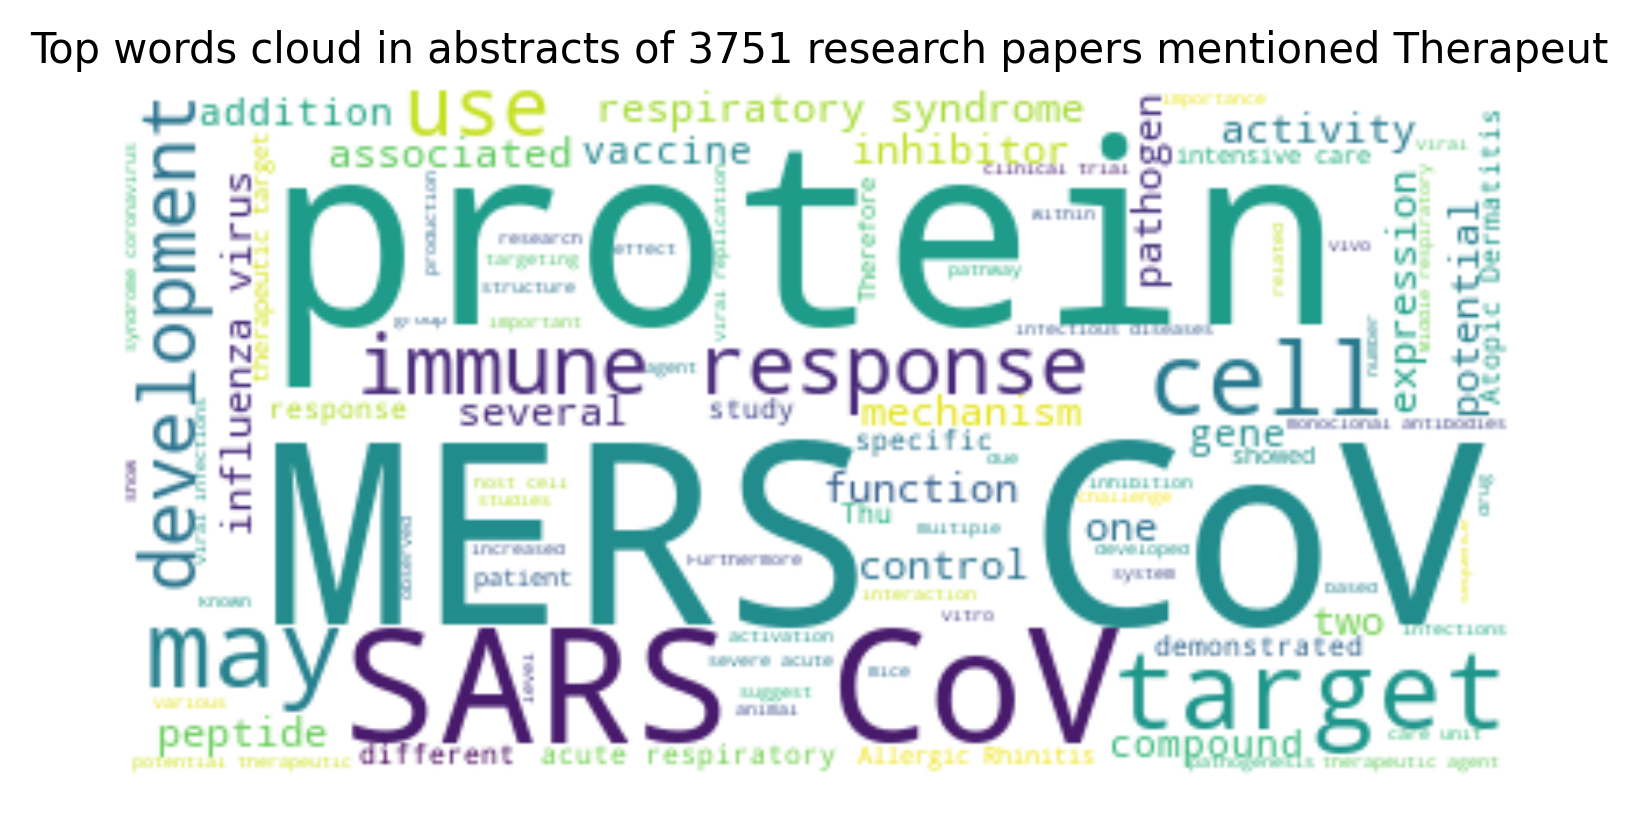

In [0]:
text = outString

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = STOPWORDS2,  background_color="white").generate(text)

#matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 300

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Top words cloud in abstracts of ' +str(df2.abstract.shape[0])+  ' research papers mentioned Therapeut',fontsize=10)#,fontweight='bold'
plt.show()

## Vectorize the abstracts with TF-IDF

In [0]:
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',max_features = 2**12)
tf_idf = tf_idf_vectorizor.fit_transform(df2.abstract)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

000  001   01   04   05        10  ...  șerban   β1   κb   λ3   μg   μm
0  0.0  0.0  0.0  0.0  0.0  0.000000  ...     0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.050576  ...     0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.000000  ...     0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.000000  ...     0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.000000  ...     0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 4096 columns]

## KMeans Clustering

#### Try 4 clusters

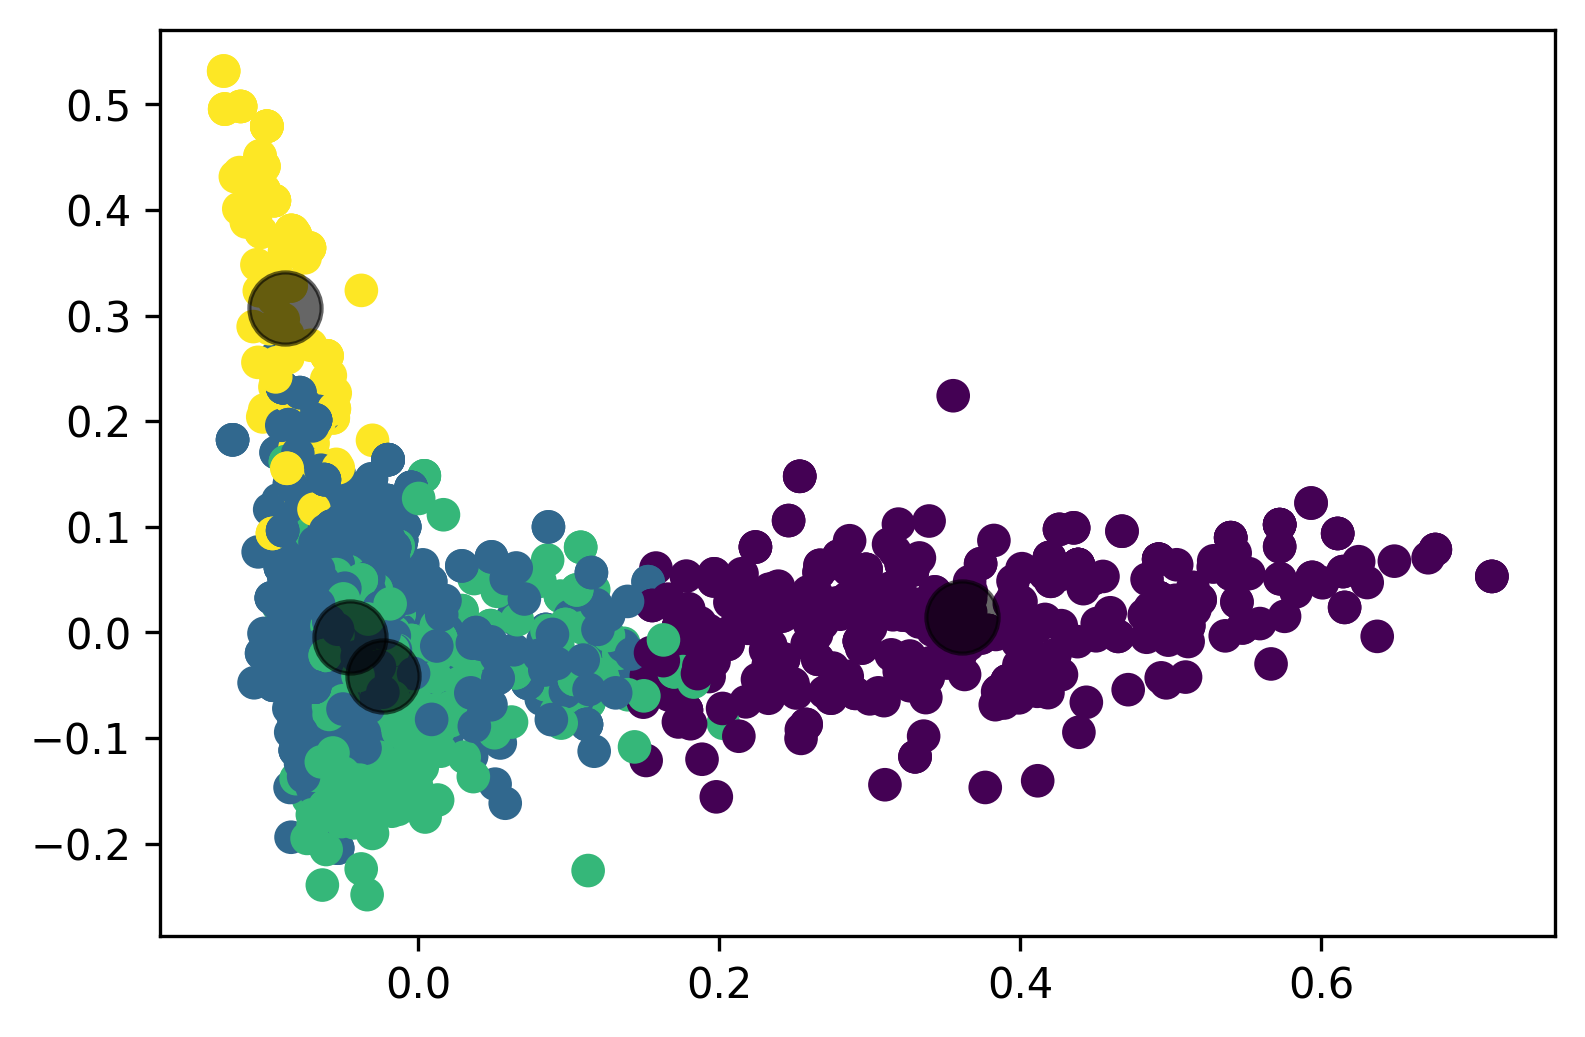

In [0]:
sklearn_pca = PCA(n_components = 30)
X = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X)
prediction = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=prediction, s=50, cmap='viridis')
centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

#### Plot of 4 clusters

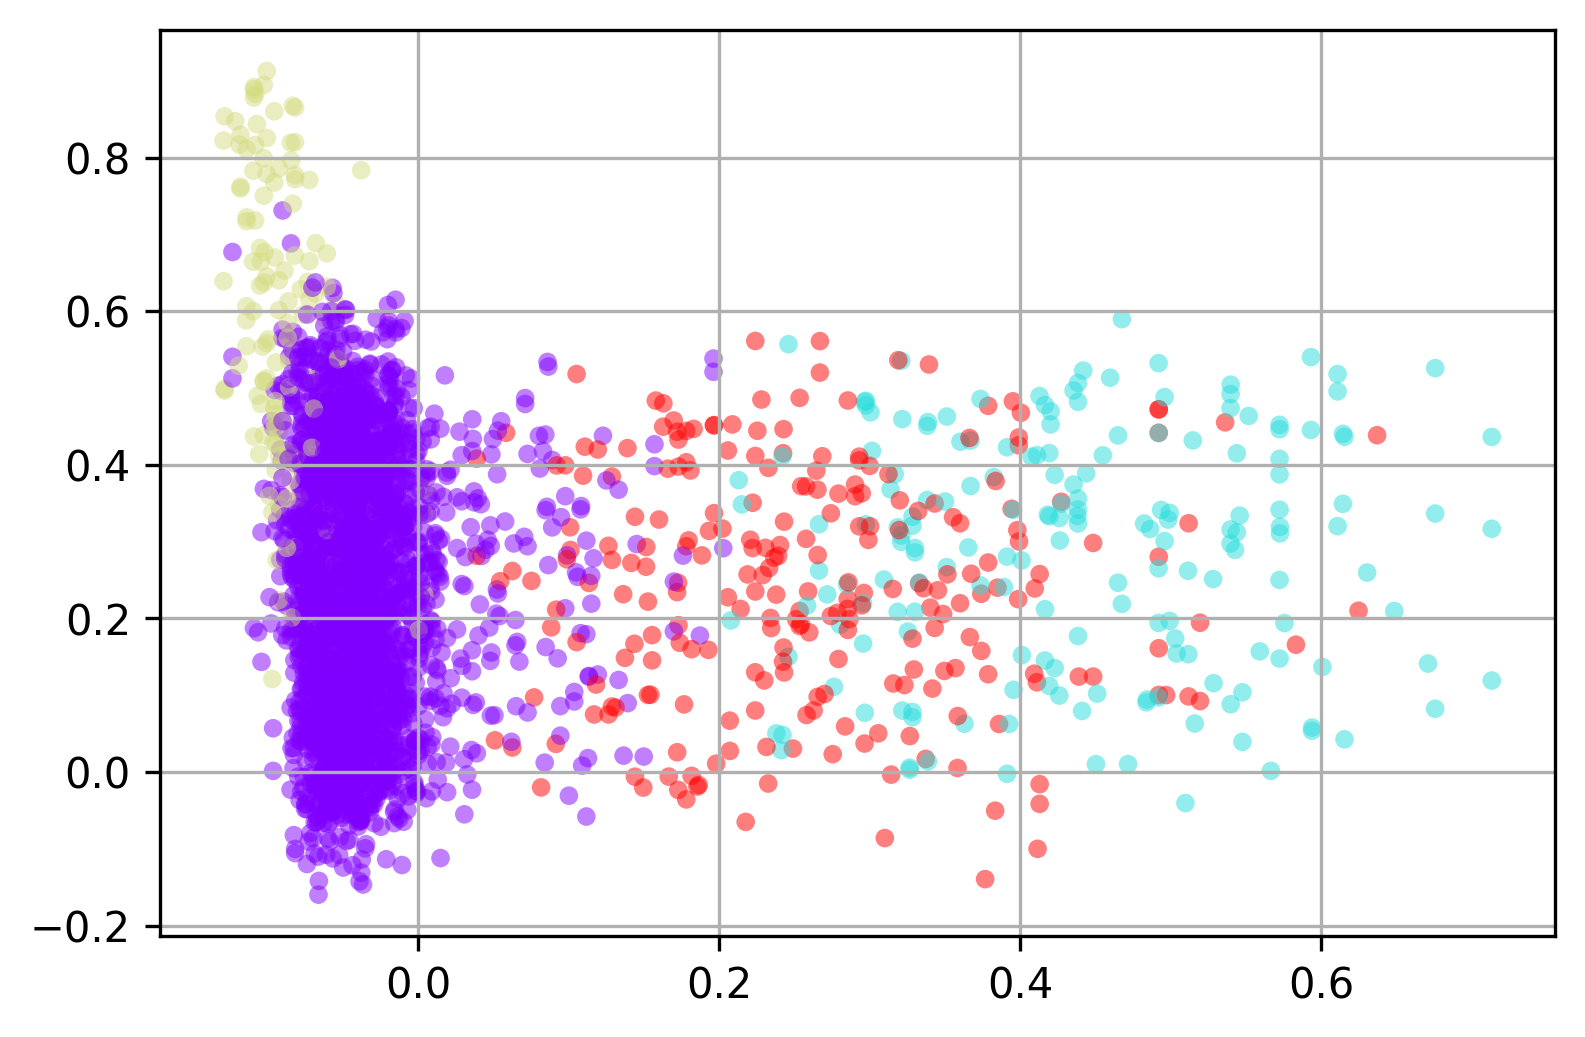

In [0]:
sklearn_pca = PCA(n_components = 30)
X = sklearn_pca.fit_transform(tf_idf_array)

cls = KMeans(n_clusters=4, init='k-means++',random_state=1) # 
cls.fit(X)
newfeature = cls.labels_ # the labels from kmeans clustering

X2 = np.column_stack((X,pd.get_dummies(newfeature)))

plt.figure()
#plt.subplot(1,2,1)
X2=X2
plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow, s=20, linewidths=0,alpha=0.5)
plt.xlabel(''), plt.ylabel('')
plt.grid()

### Plot of 4 clusters

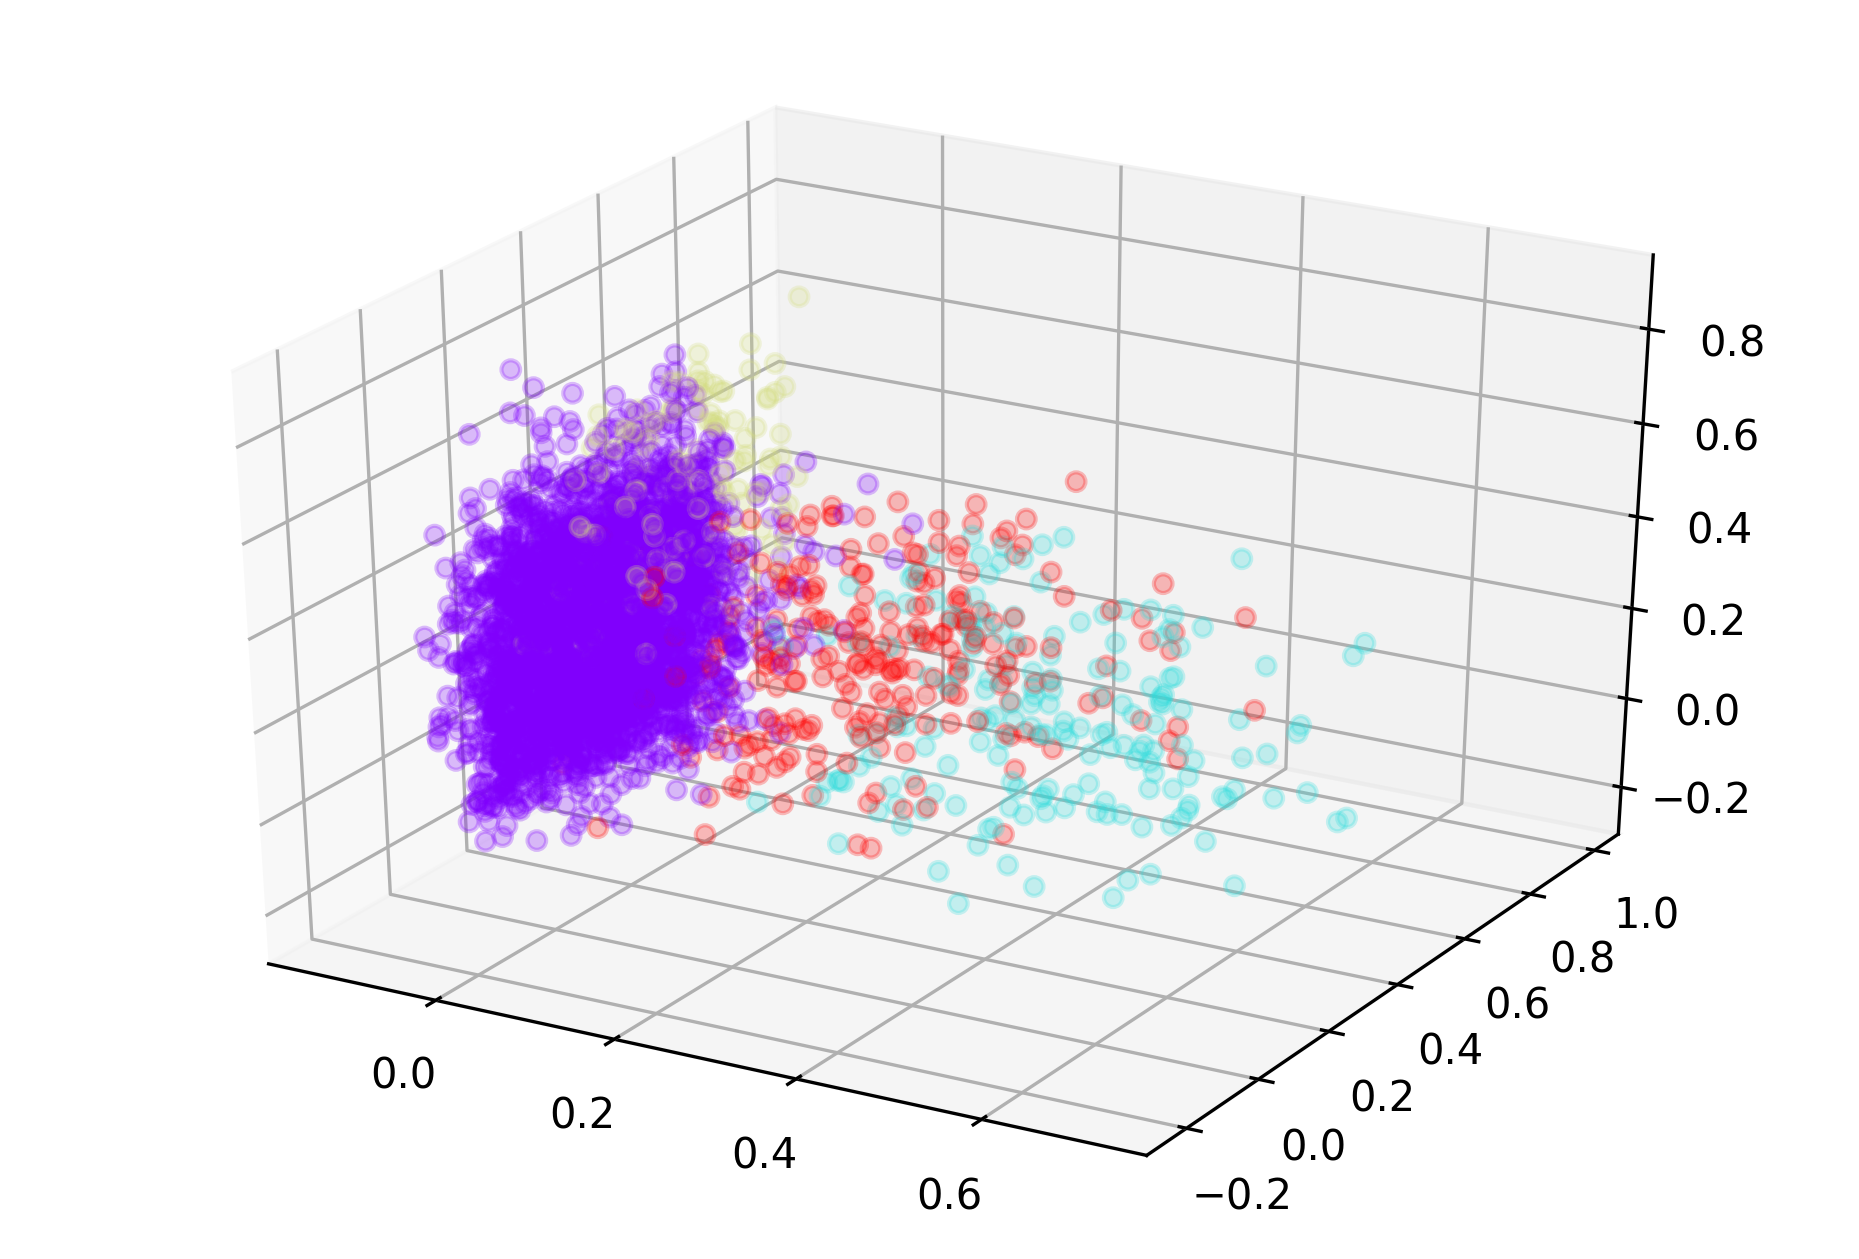

In [0]:
#3D plot

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D


fig = pyplot.figure()
ax = Axes3D(fig)


ax.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2,X2[:, 2]+np.random.random(X2[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow,alpha=0.25)
pyplot.show()

3D Plot of 4 clusters

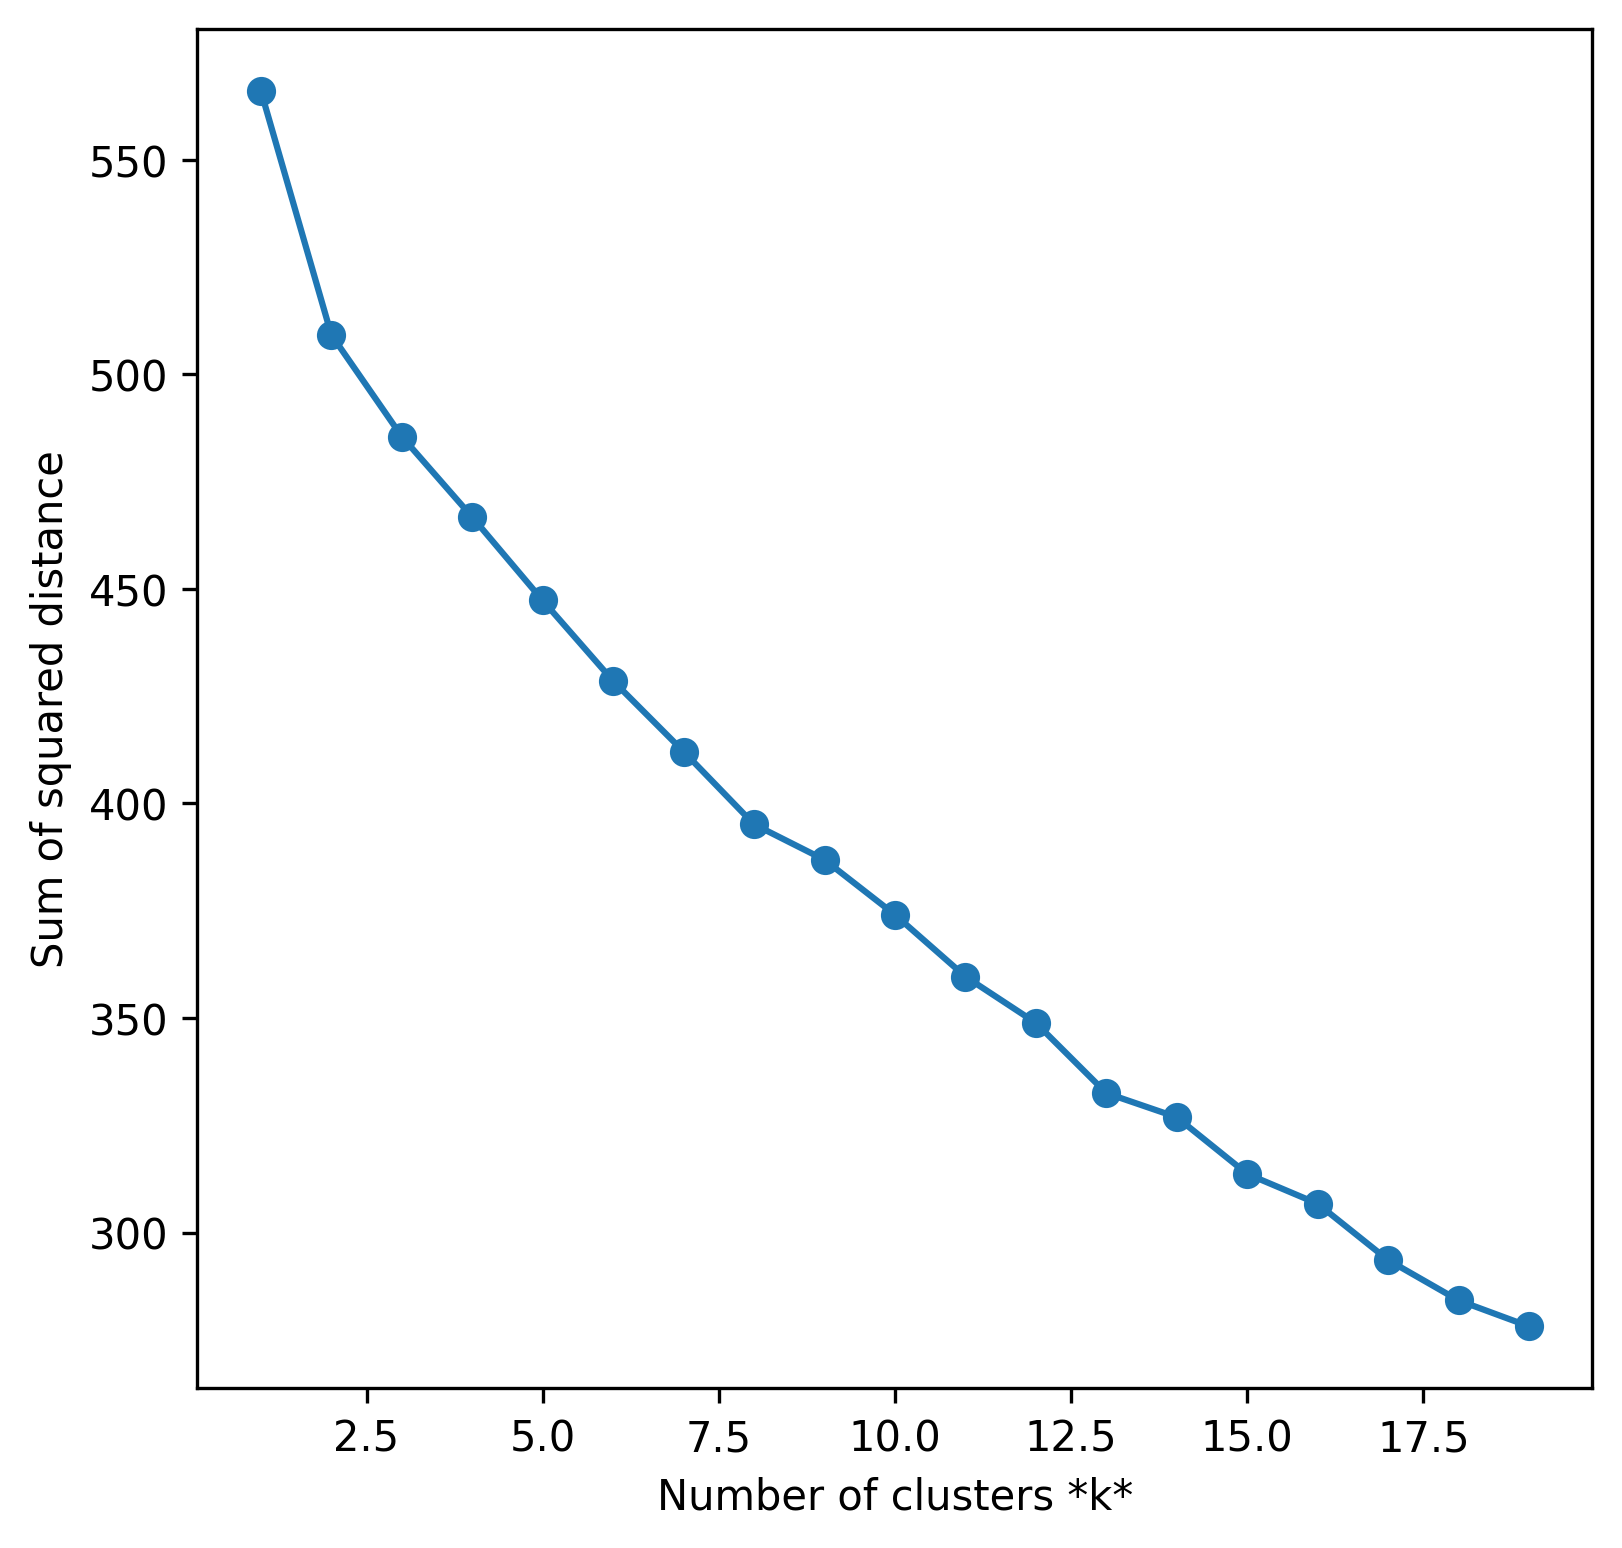

In [0]:
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

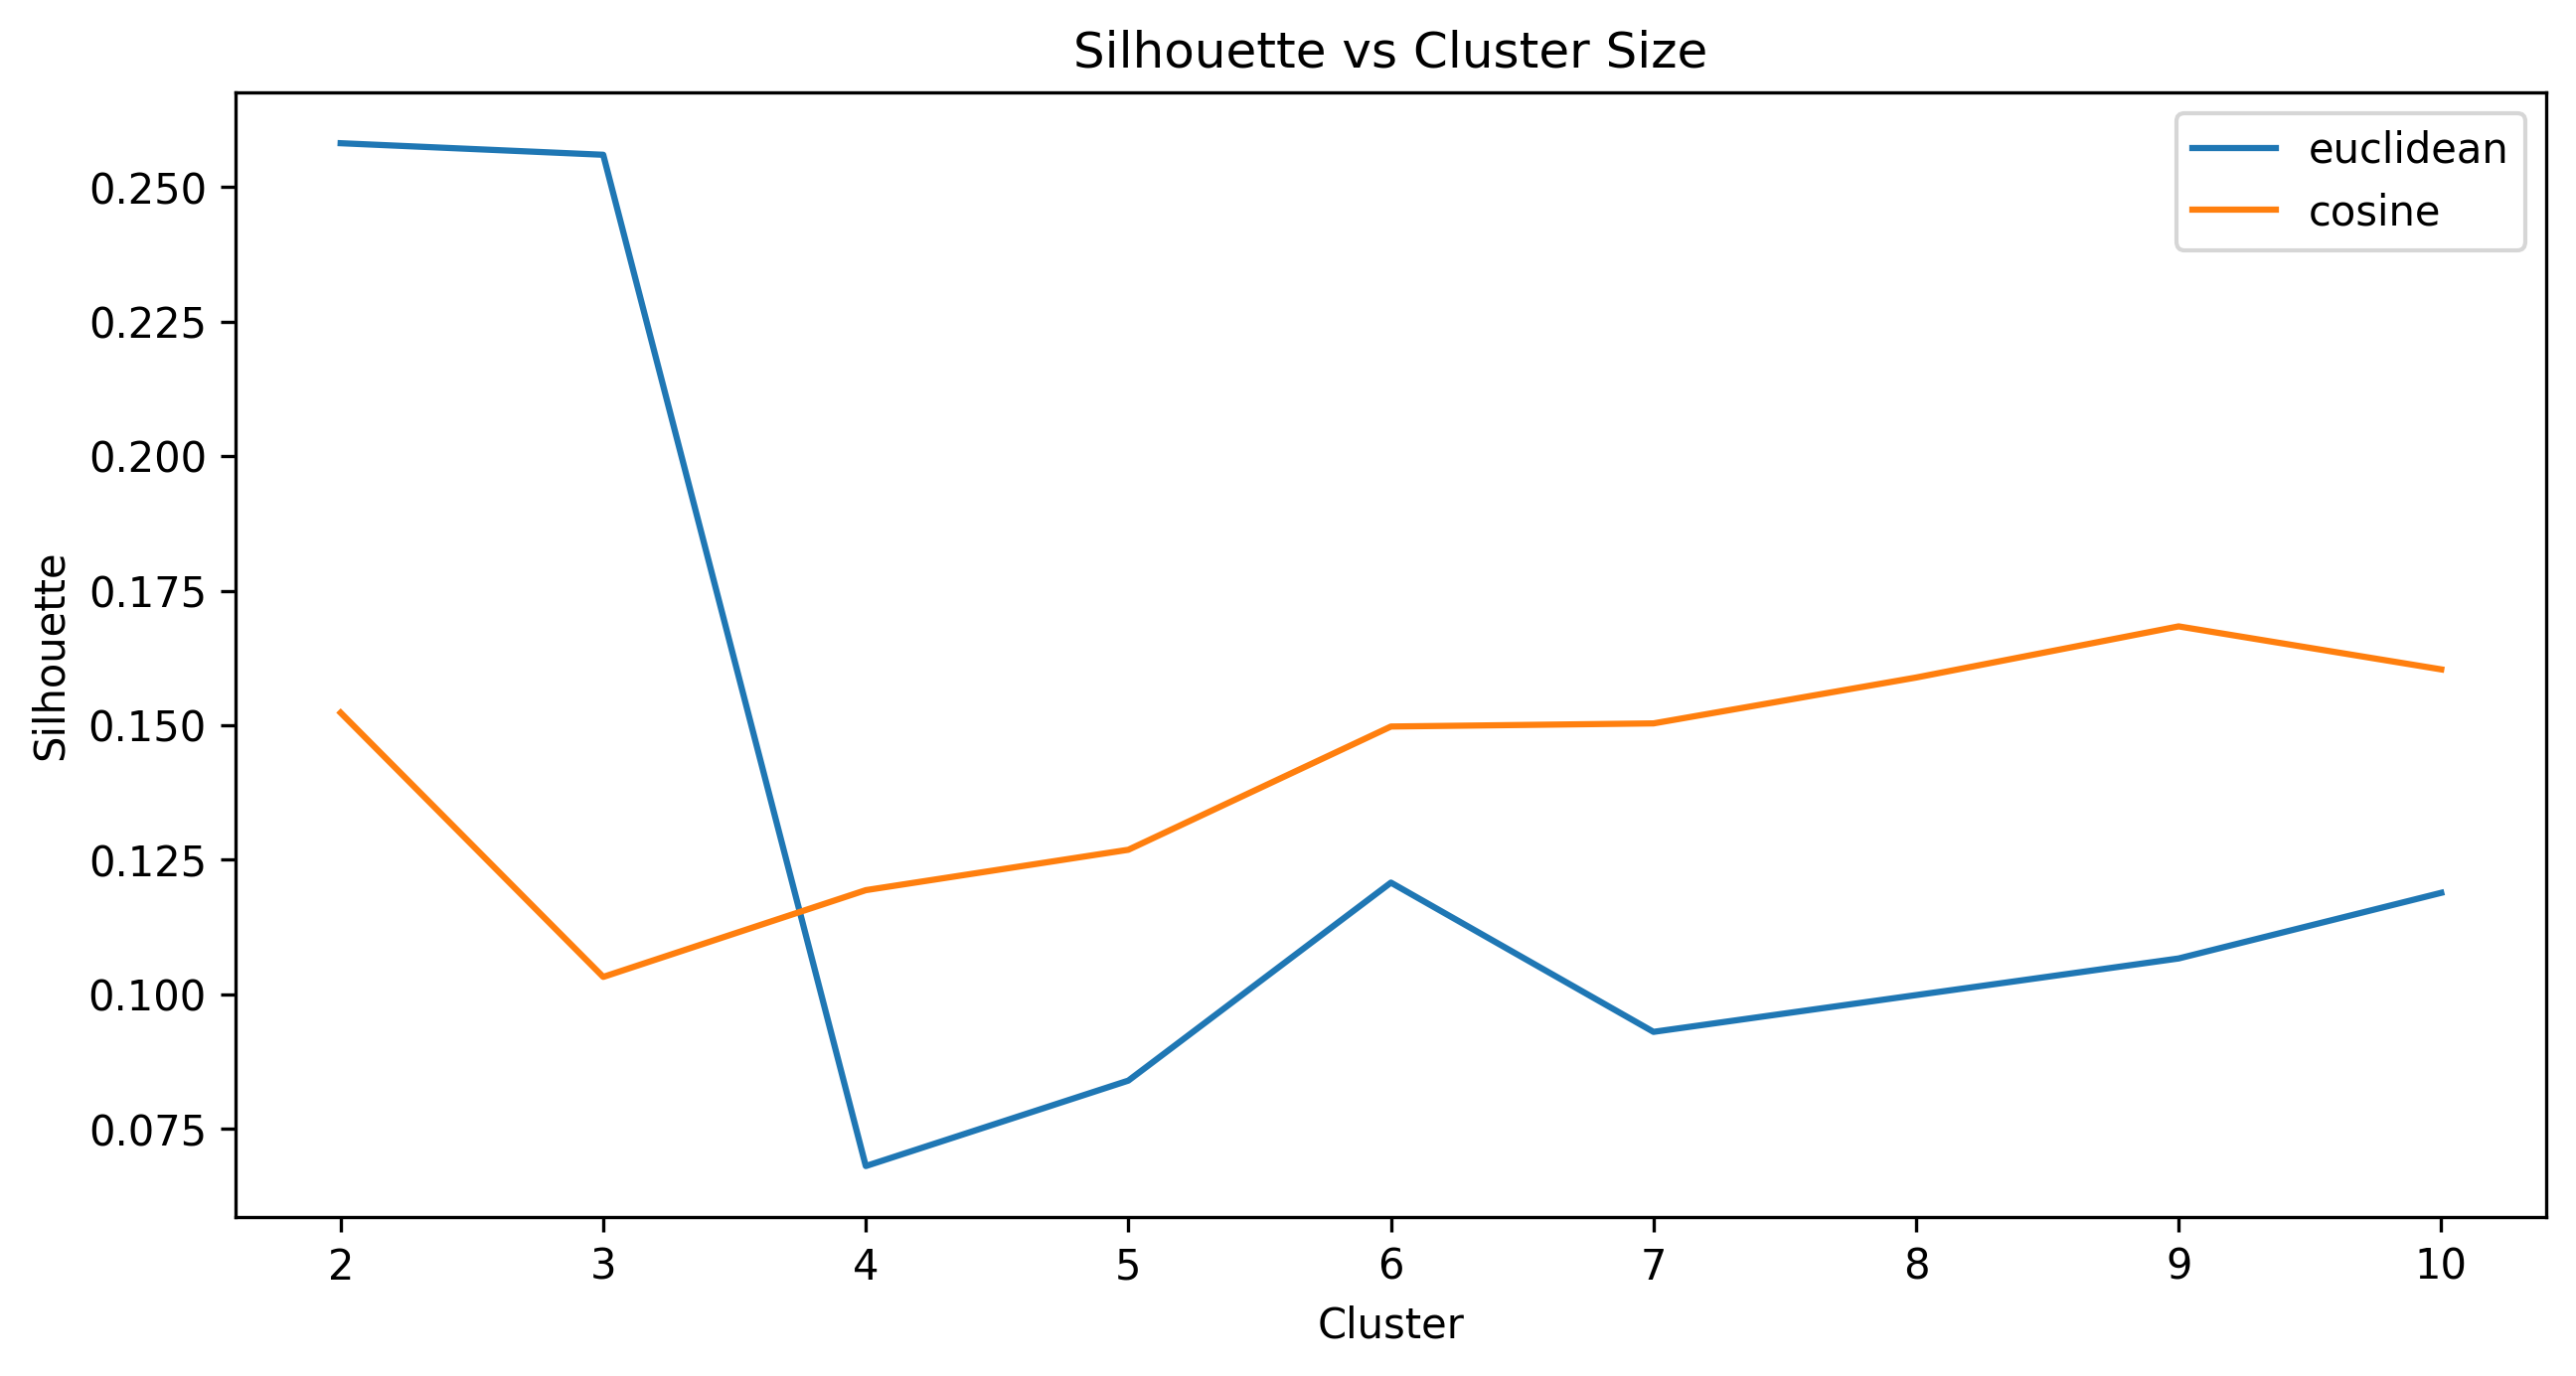

In [0]:

data=X

# Silhouette vs Cluster Size
# do it for the k-means
from sklearn import metrics
from sklearn.cluster import KMeans

seuclid = []
scosine = []
k = range(2,11)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(X)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(data, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(data, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

Automatically created module for IPython interactive environment
For n_clusters = 3 The average silhouette_score is : 0.60008702243698
For n_clusters = 4 The average silhouette_score is : 0.6362037988456782
For n_clusters = 5 The average silhouette_score is : 0.6747637110467222
For n_clusters = 6 The average silhouette_score is : 0.7046184267934577
For n_clusters = 7 The average silhouette_score is : 0.6296218291869989
For n_clusters = 8 The average silhouette_score is : 0.307981360959359
For n_clusters = 9 The average silhouette_score is : 0.35235657270983023
For n_clusters = 10 The average silhouette_score is : 0.36545835890078593
For n_clusters = 11 The average silhouette_score is : 0.29914606799408433


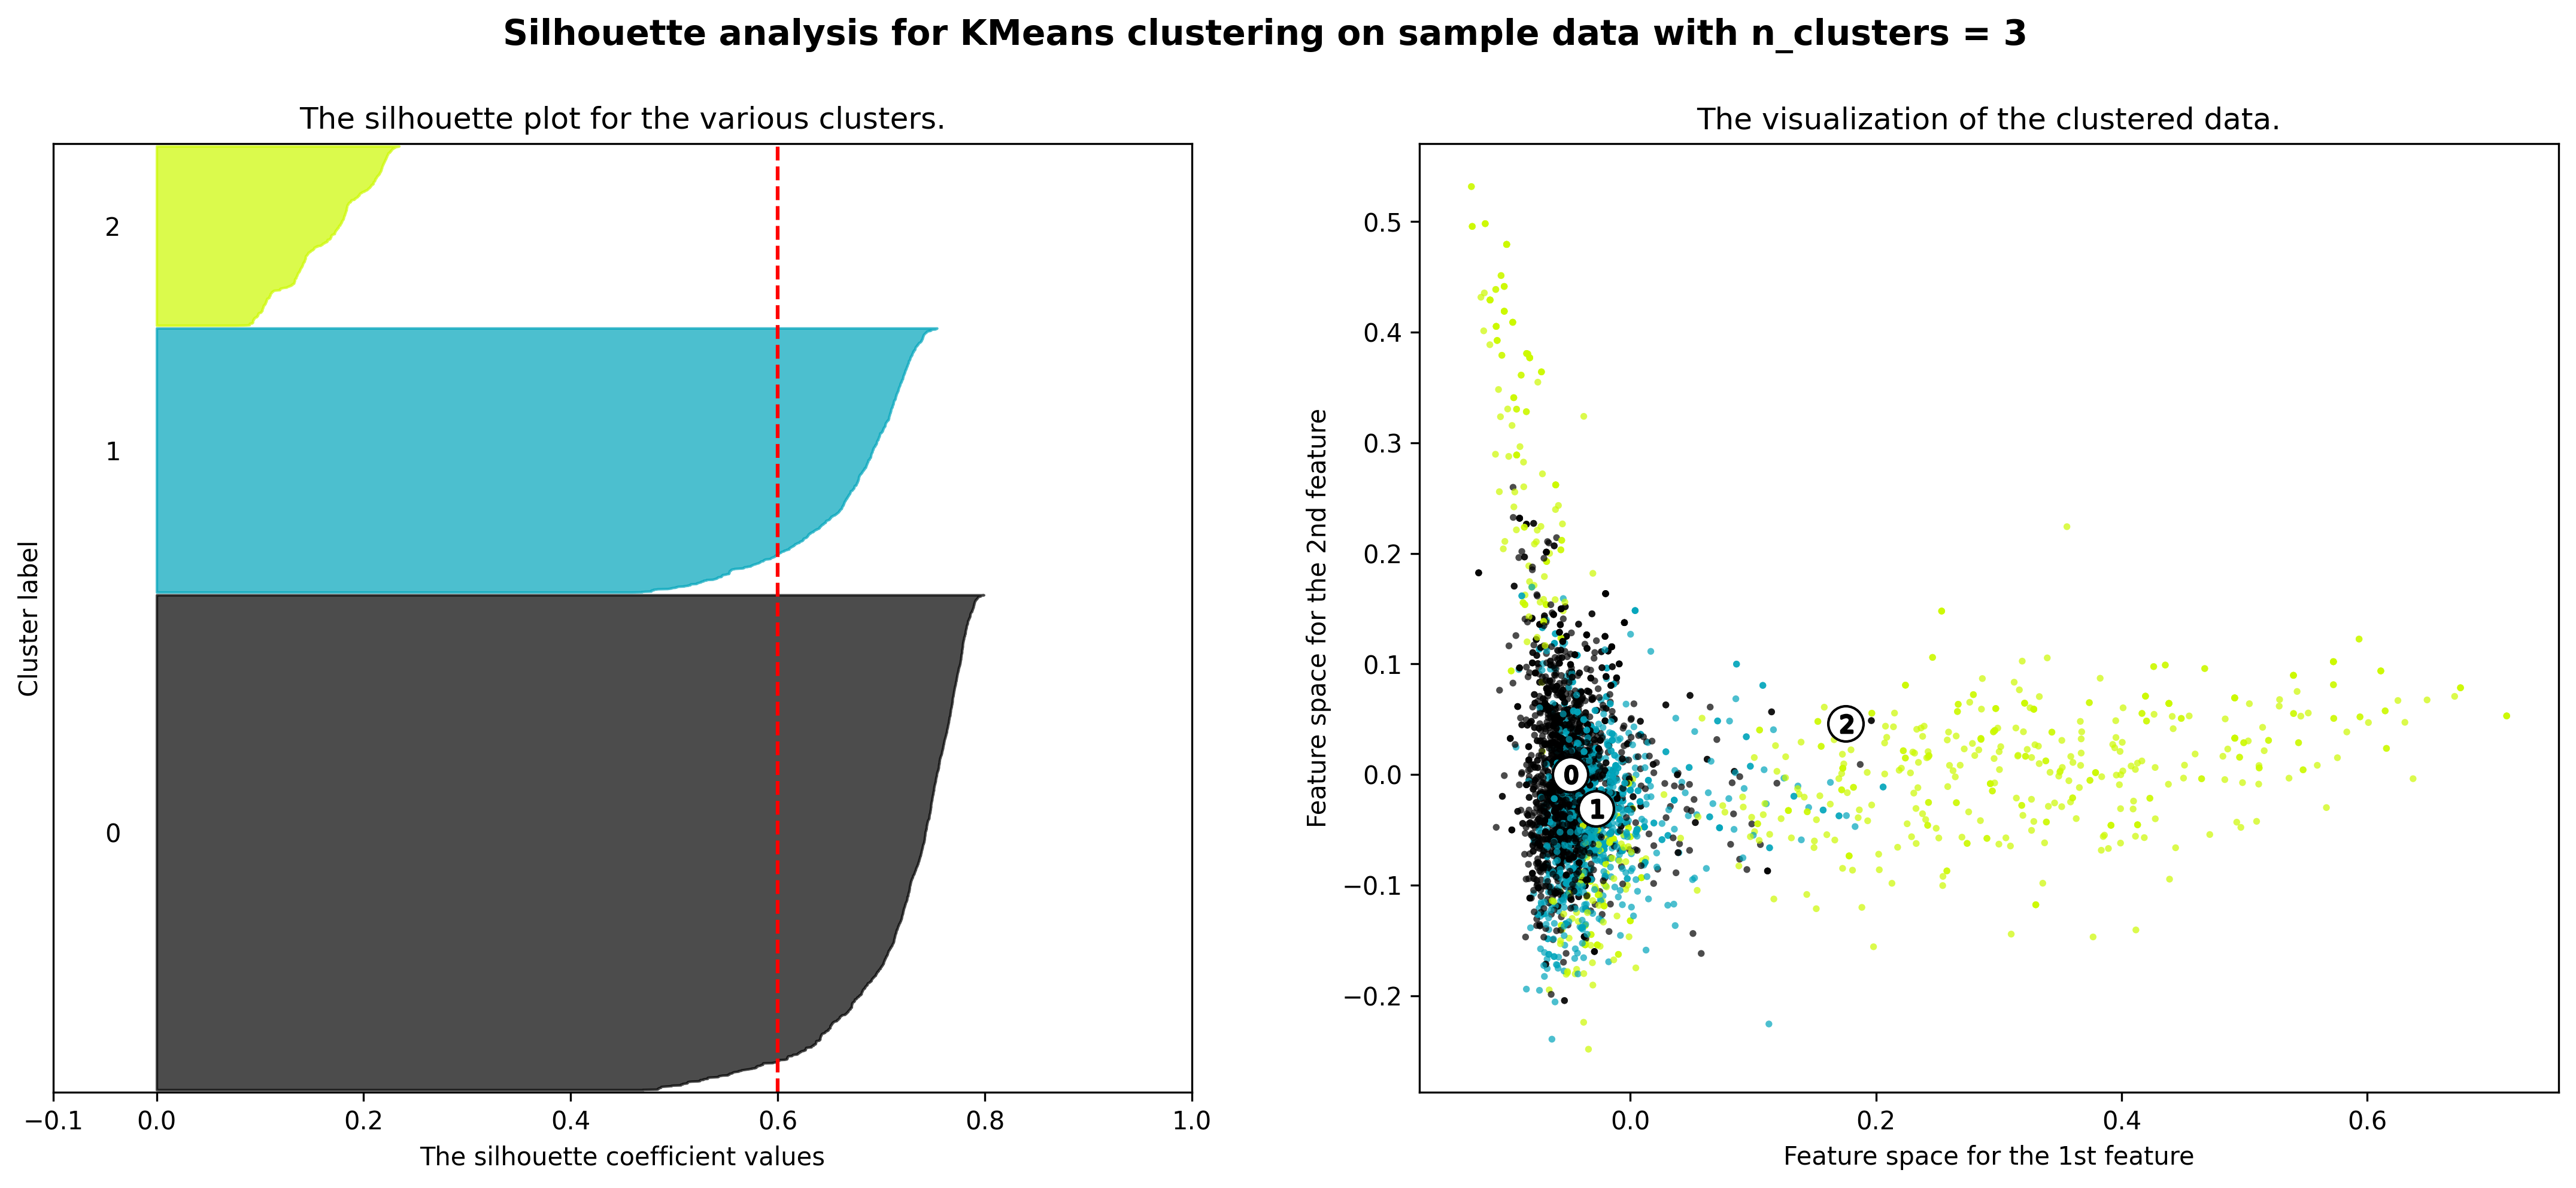

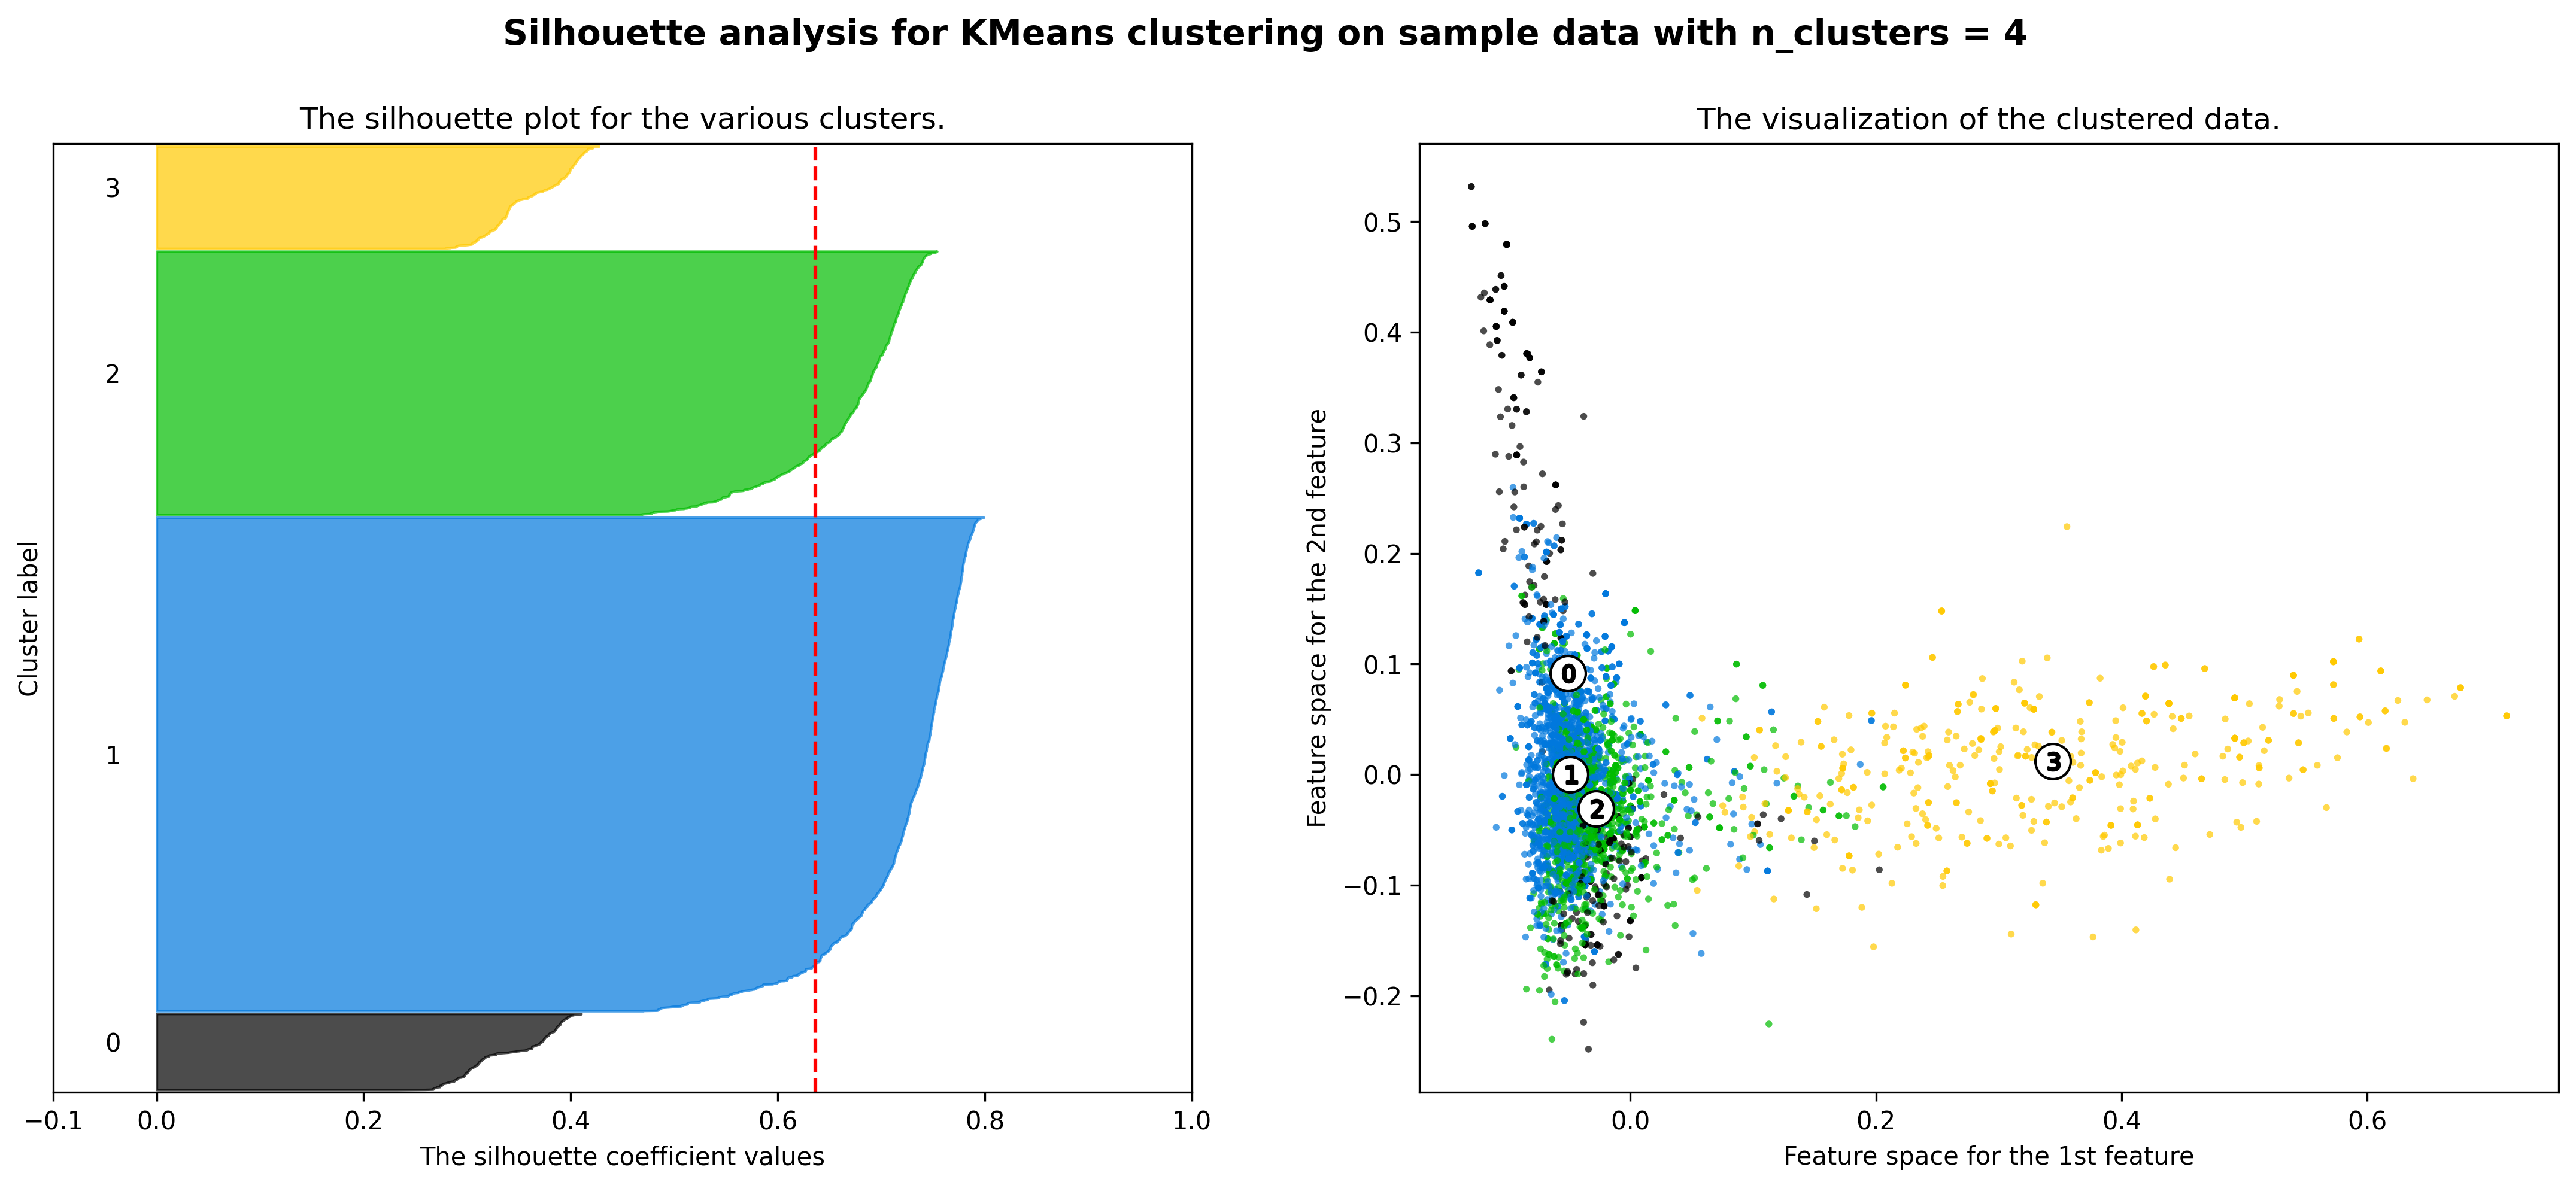

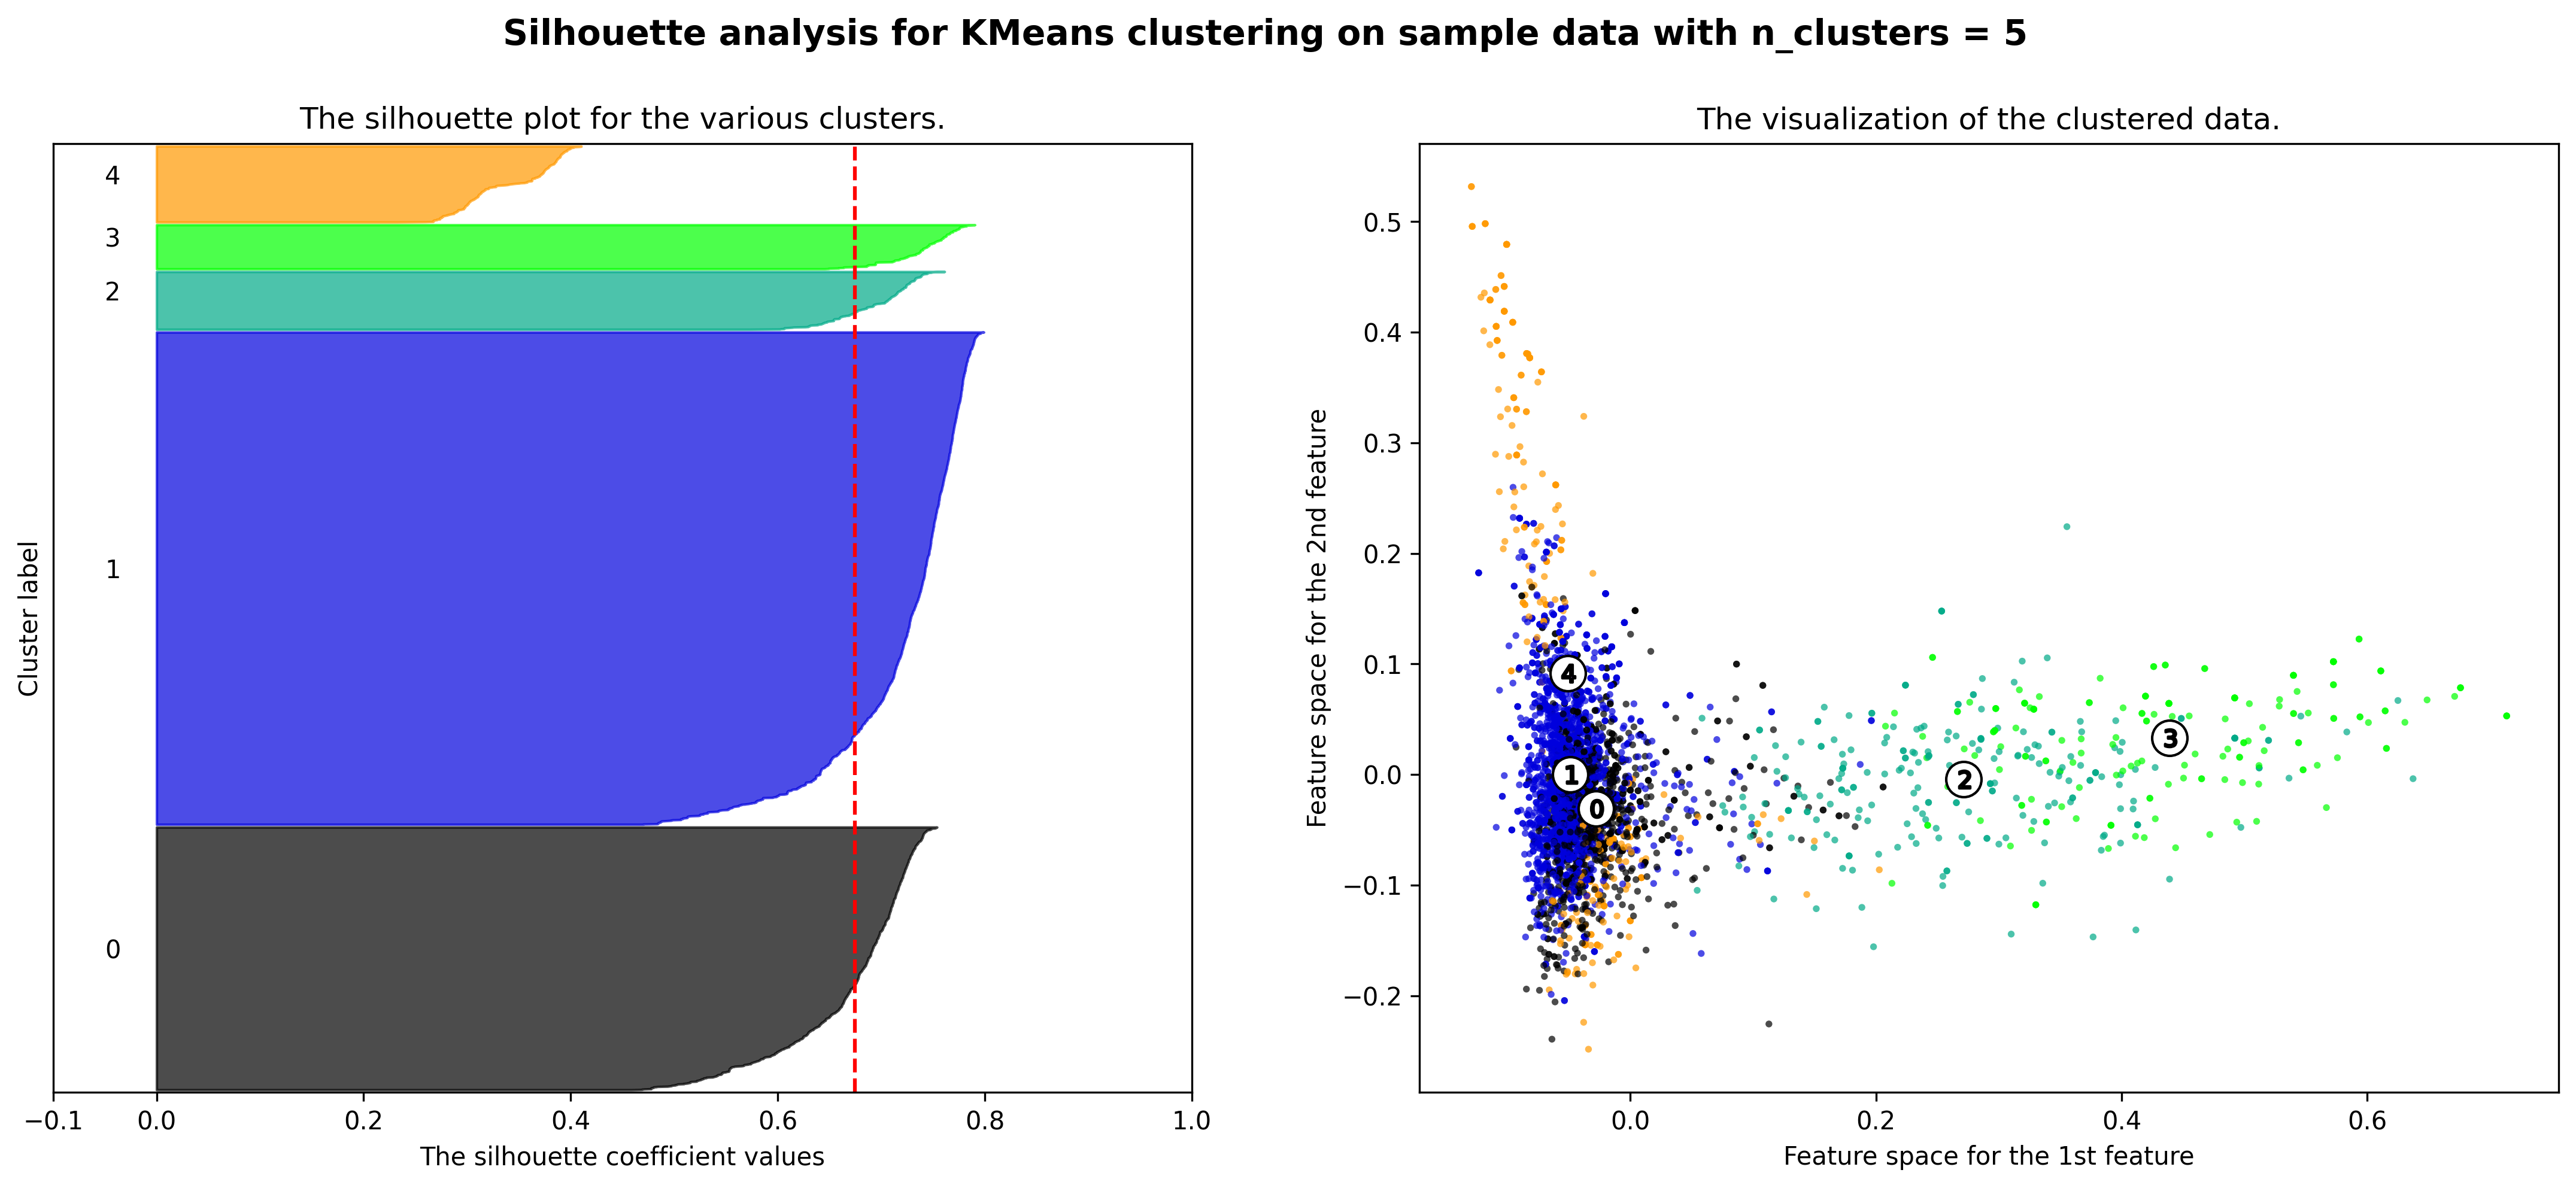

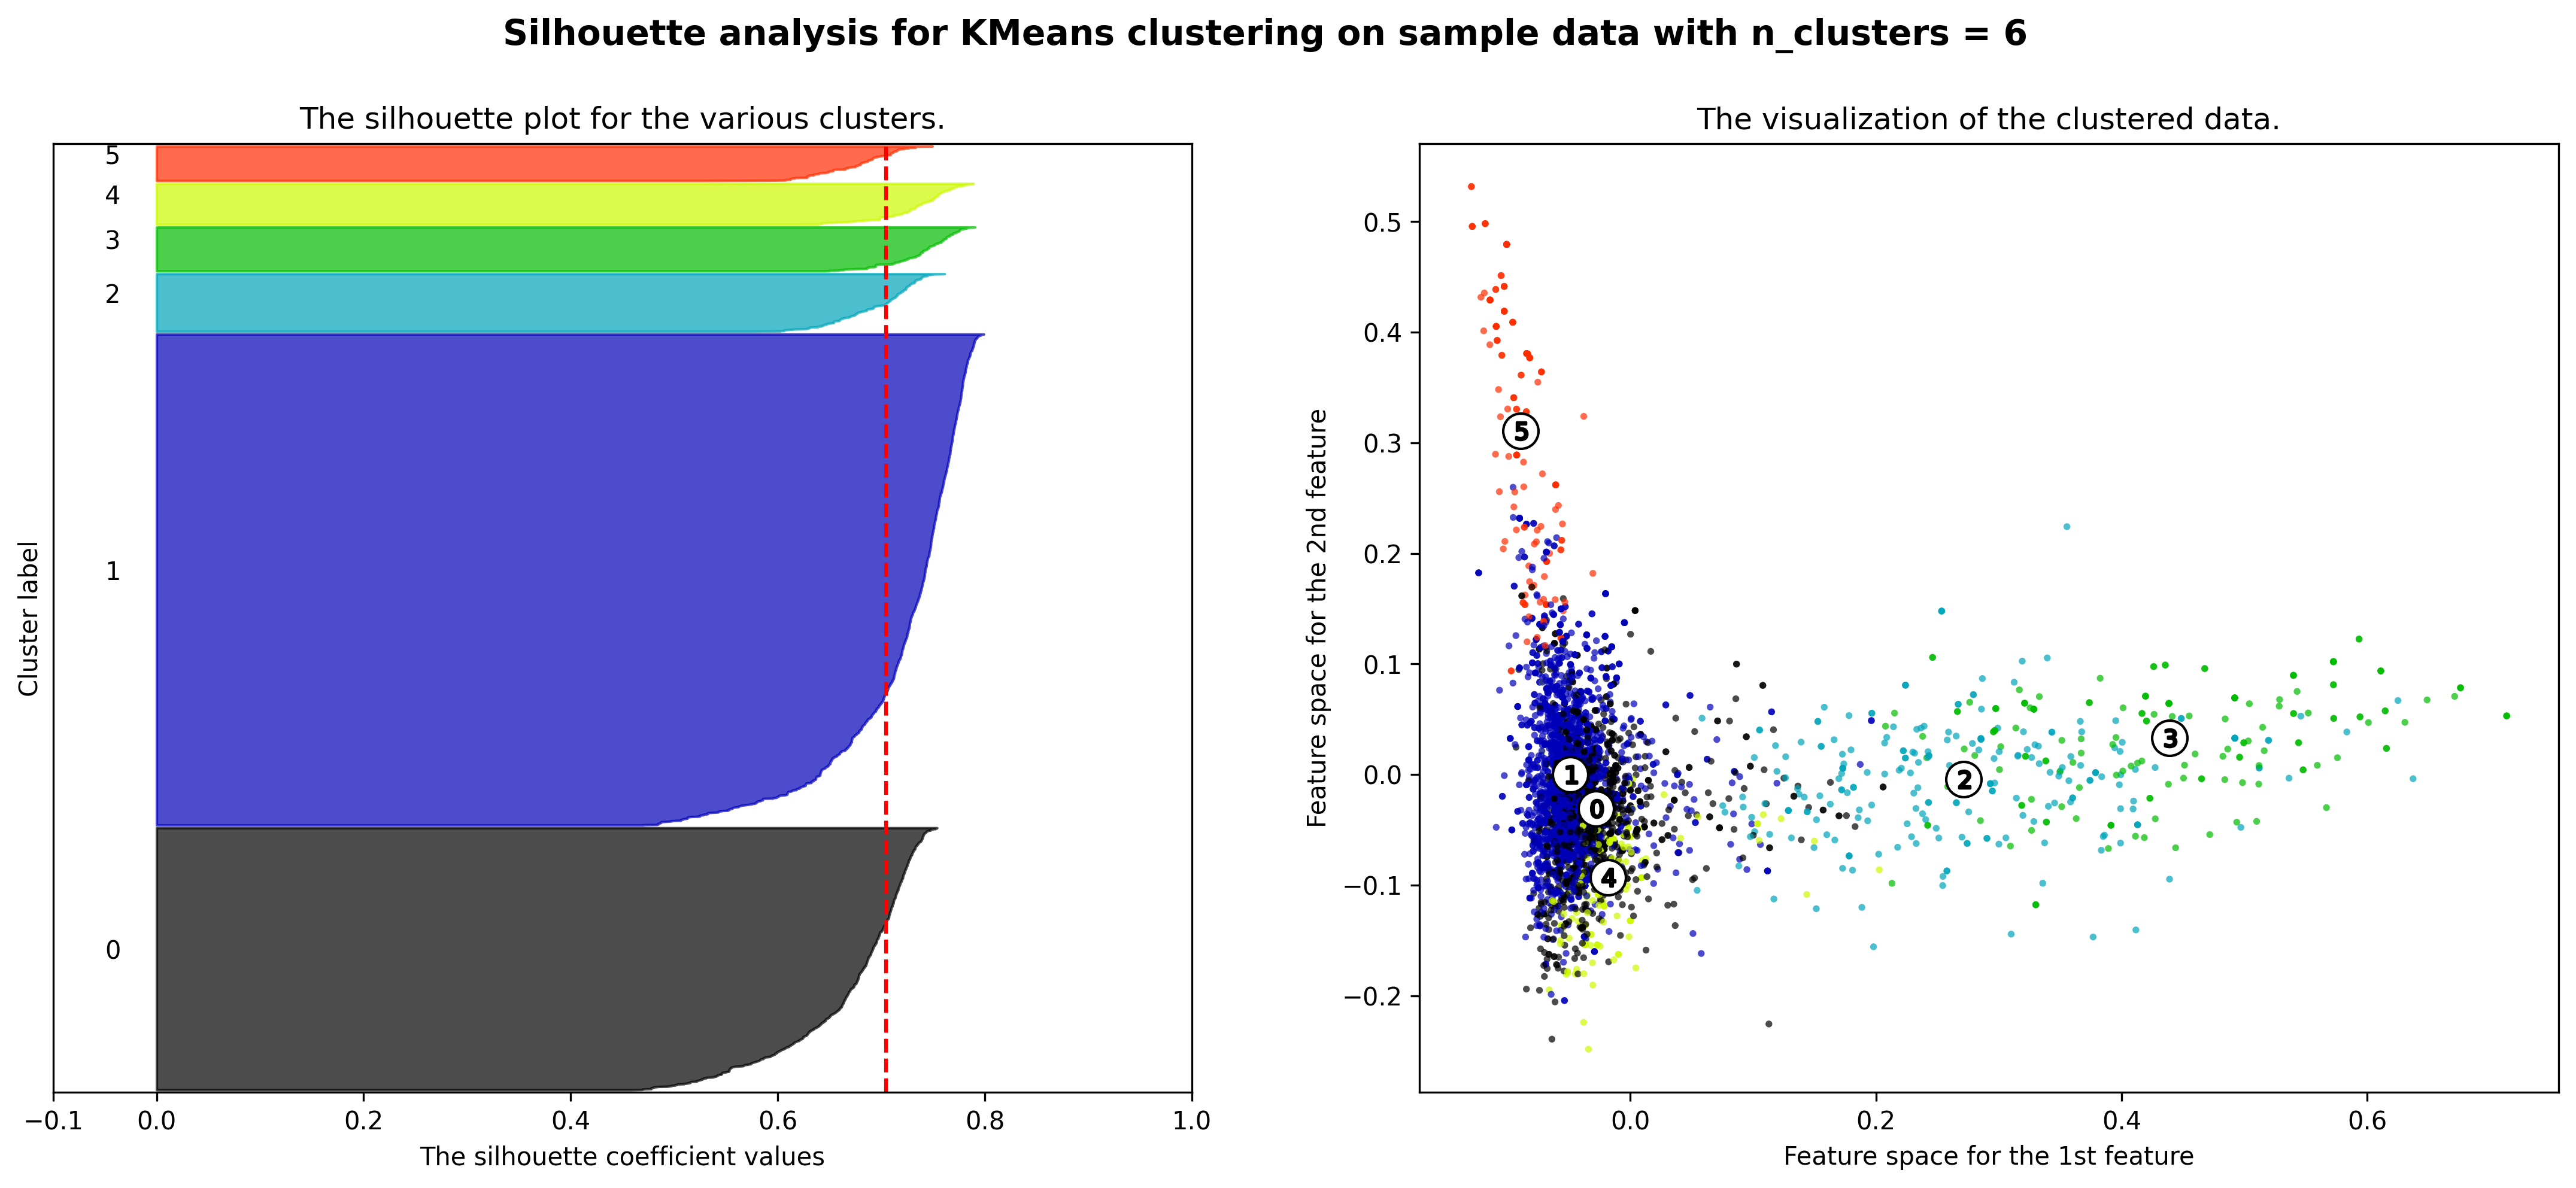

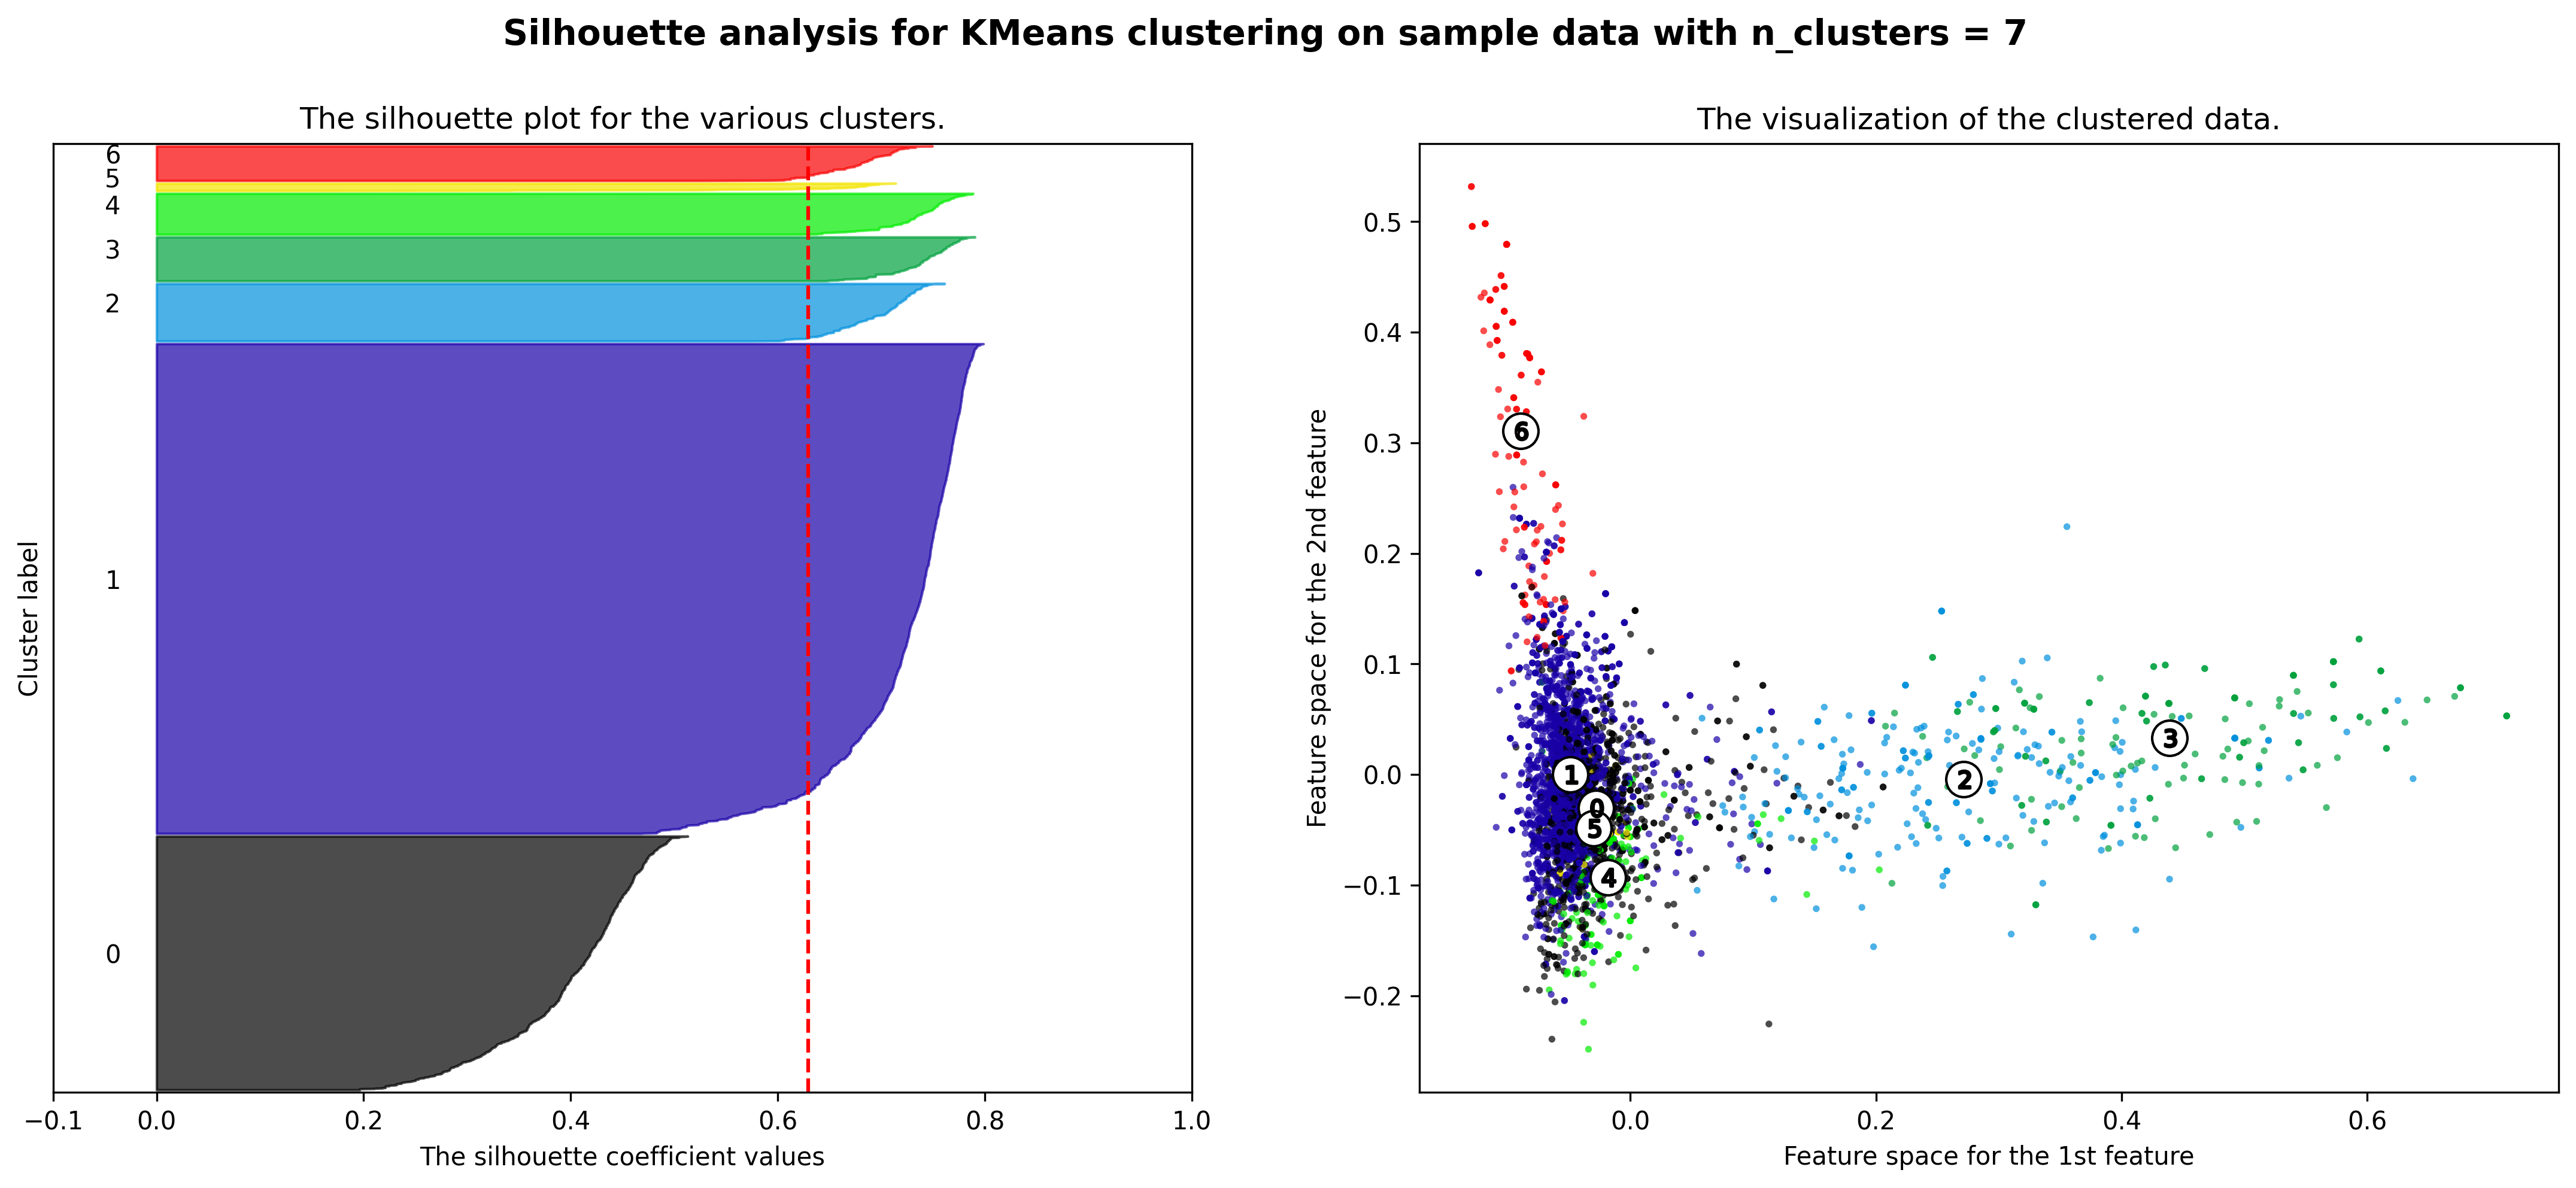

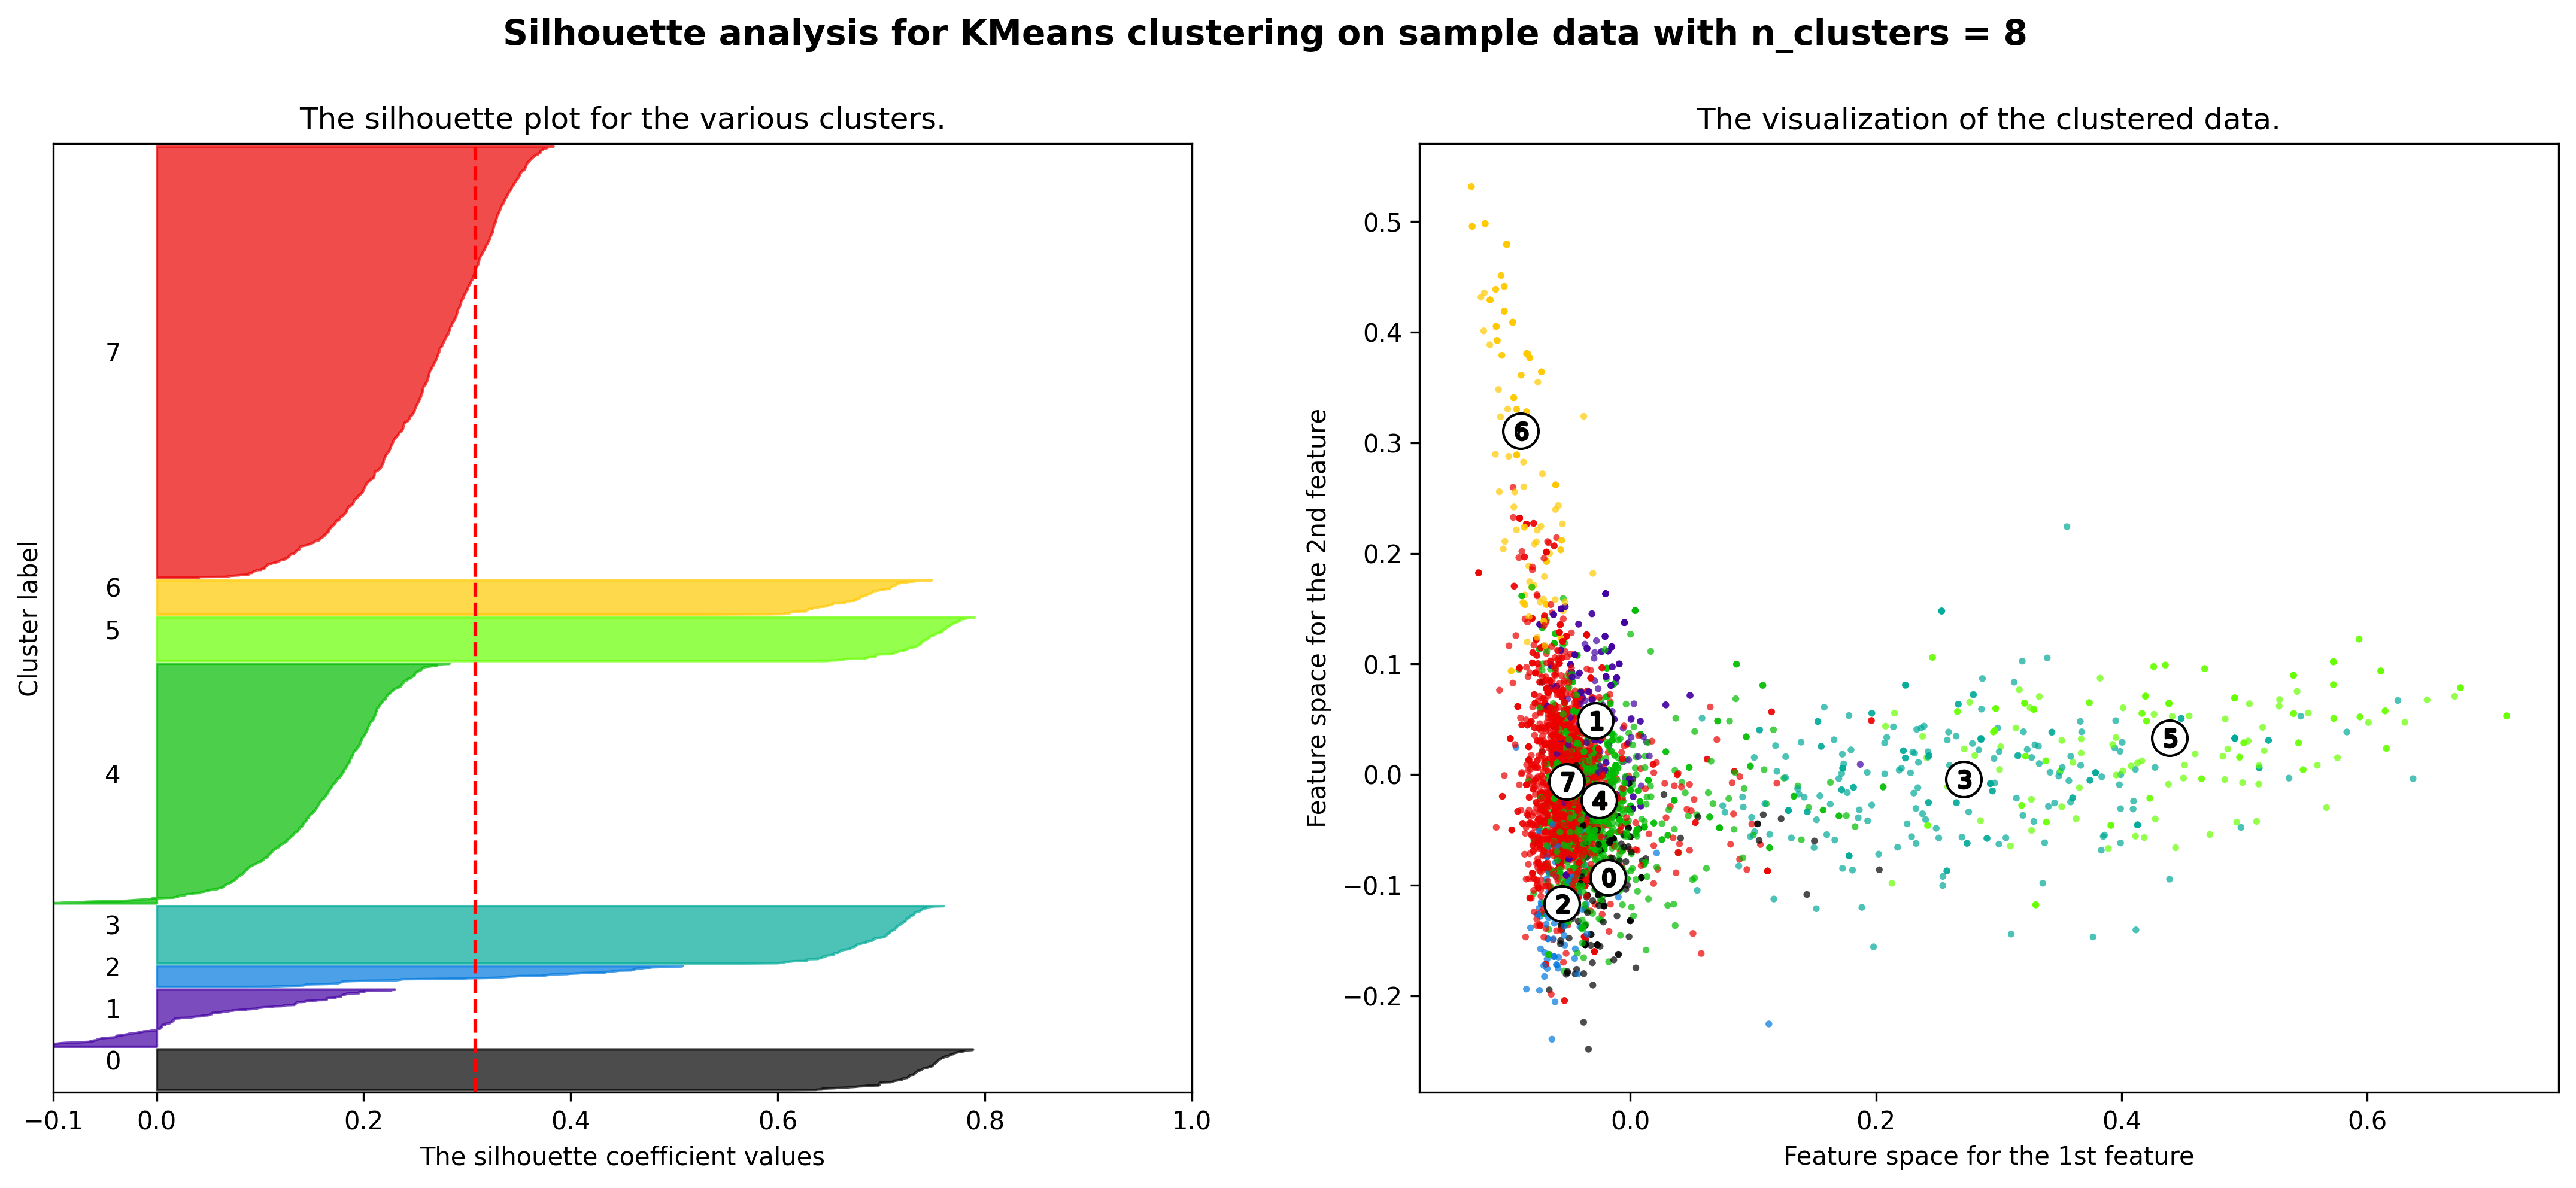

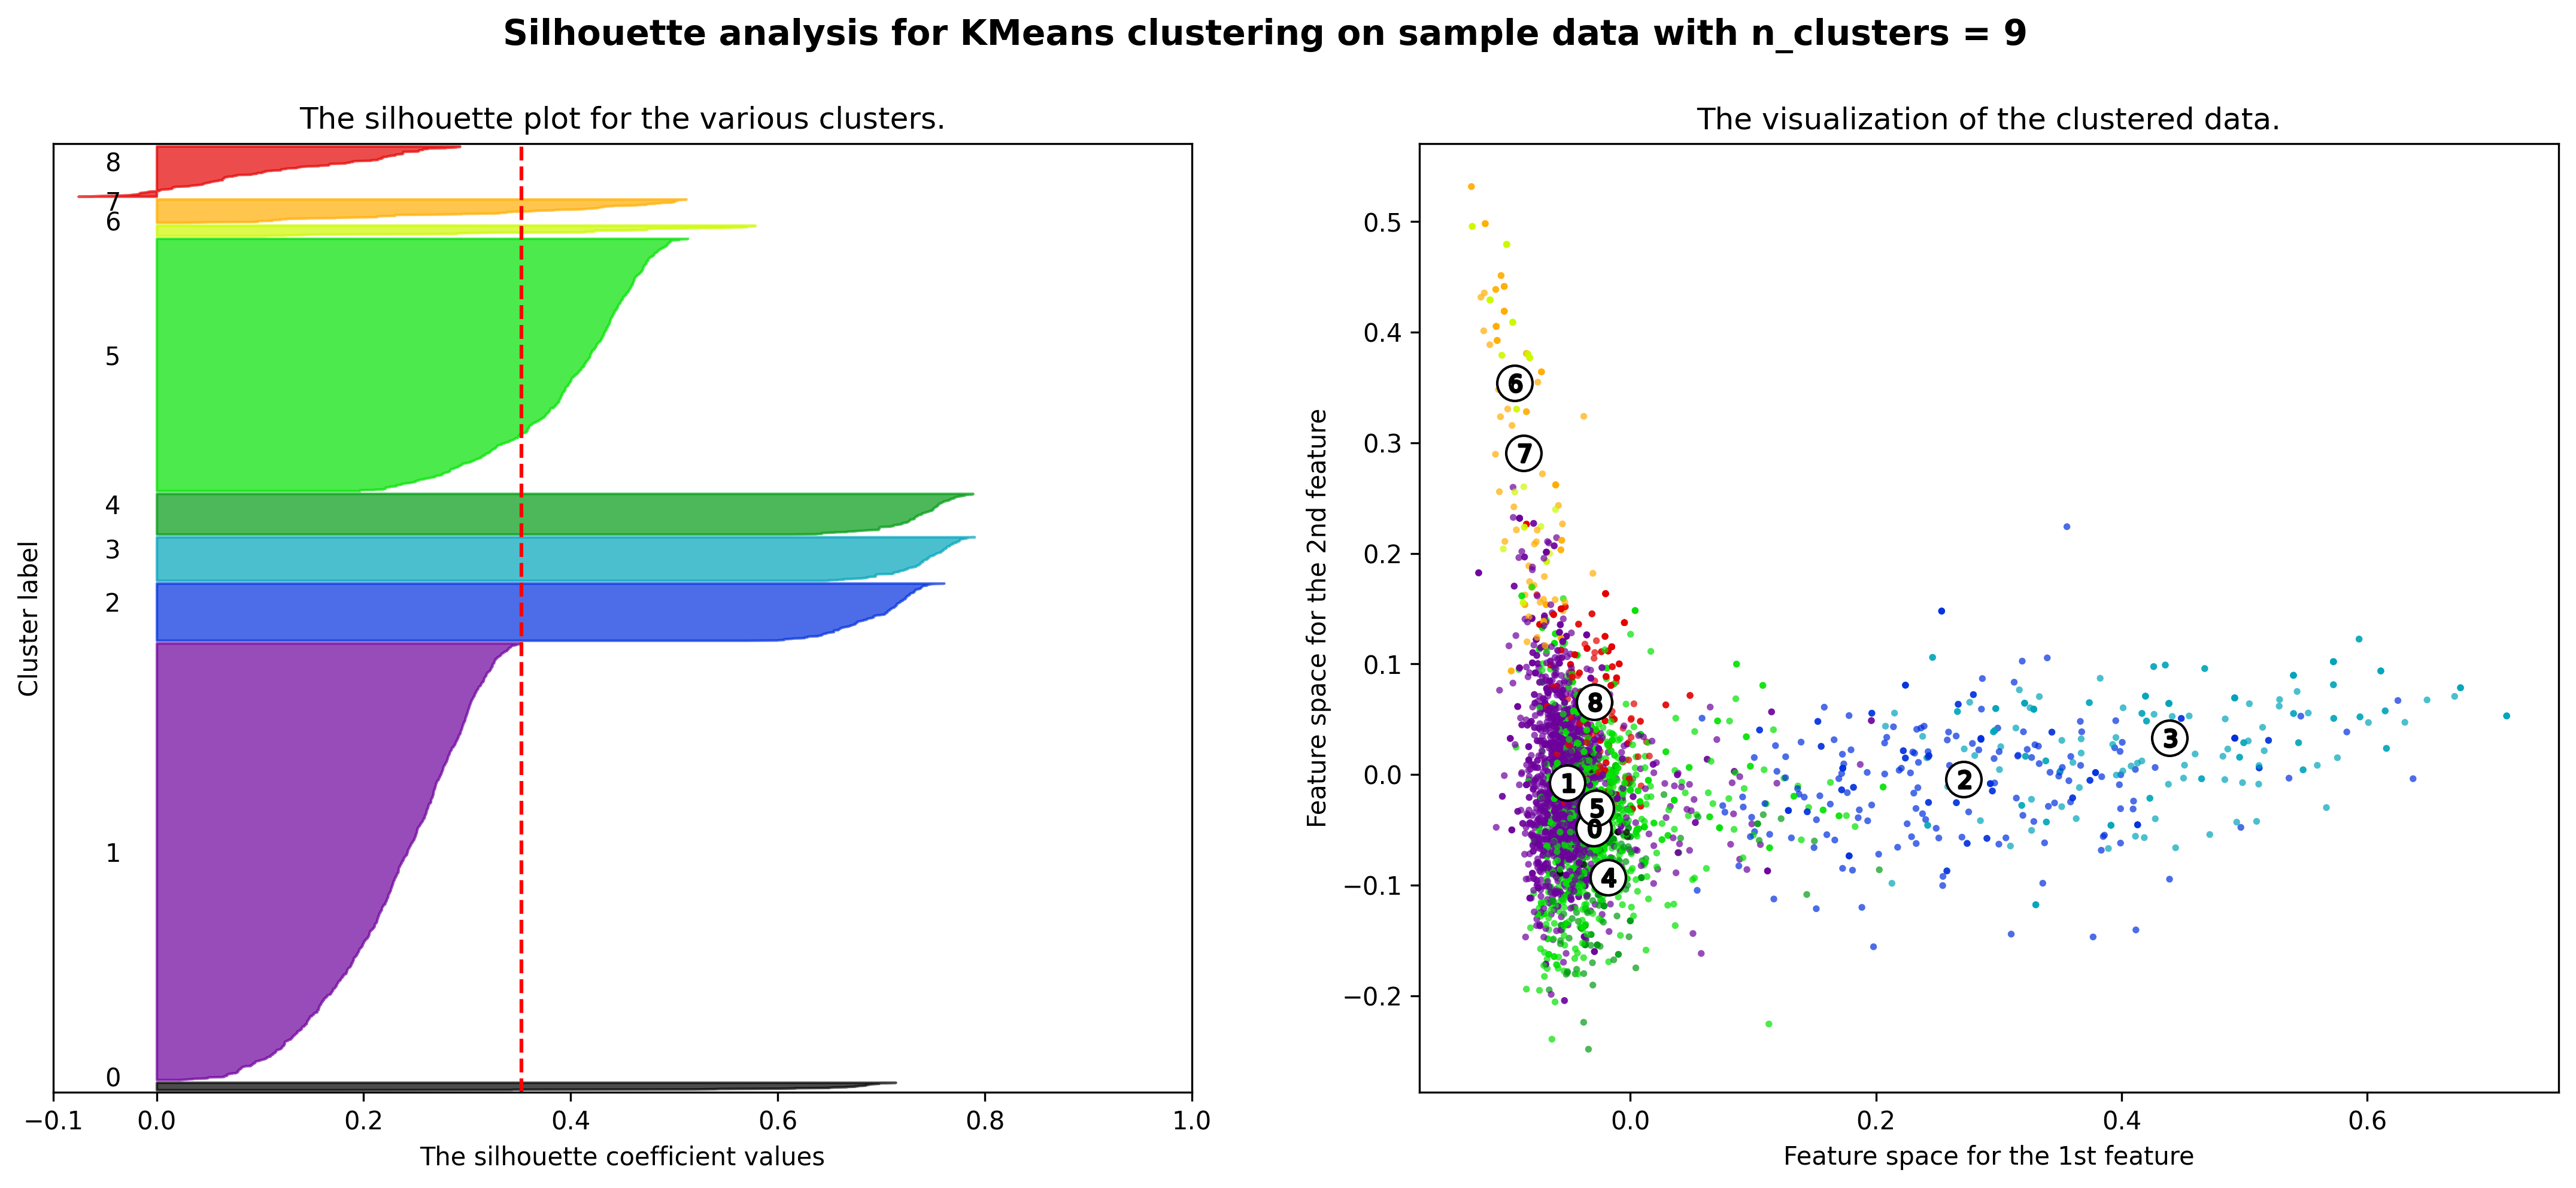

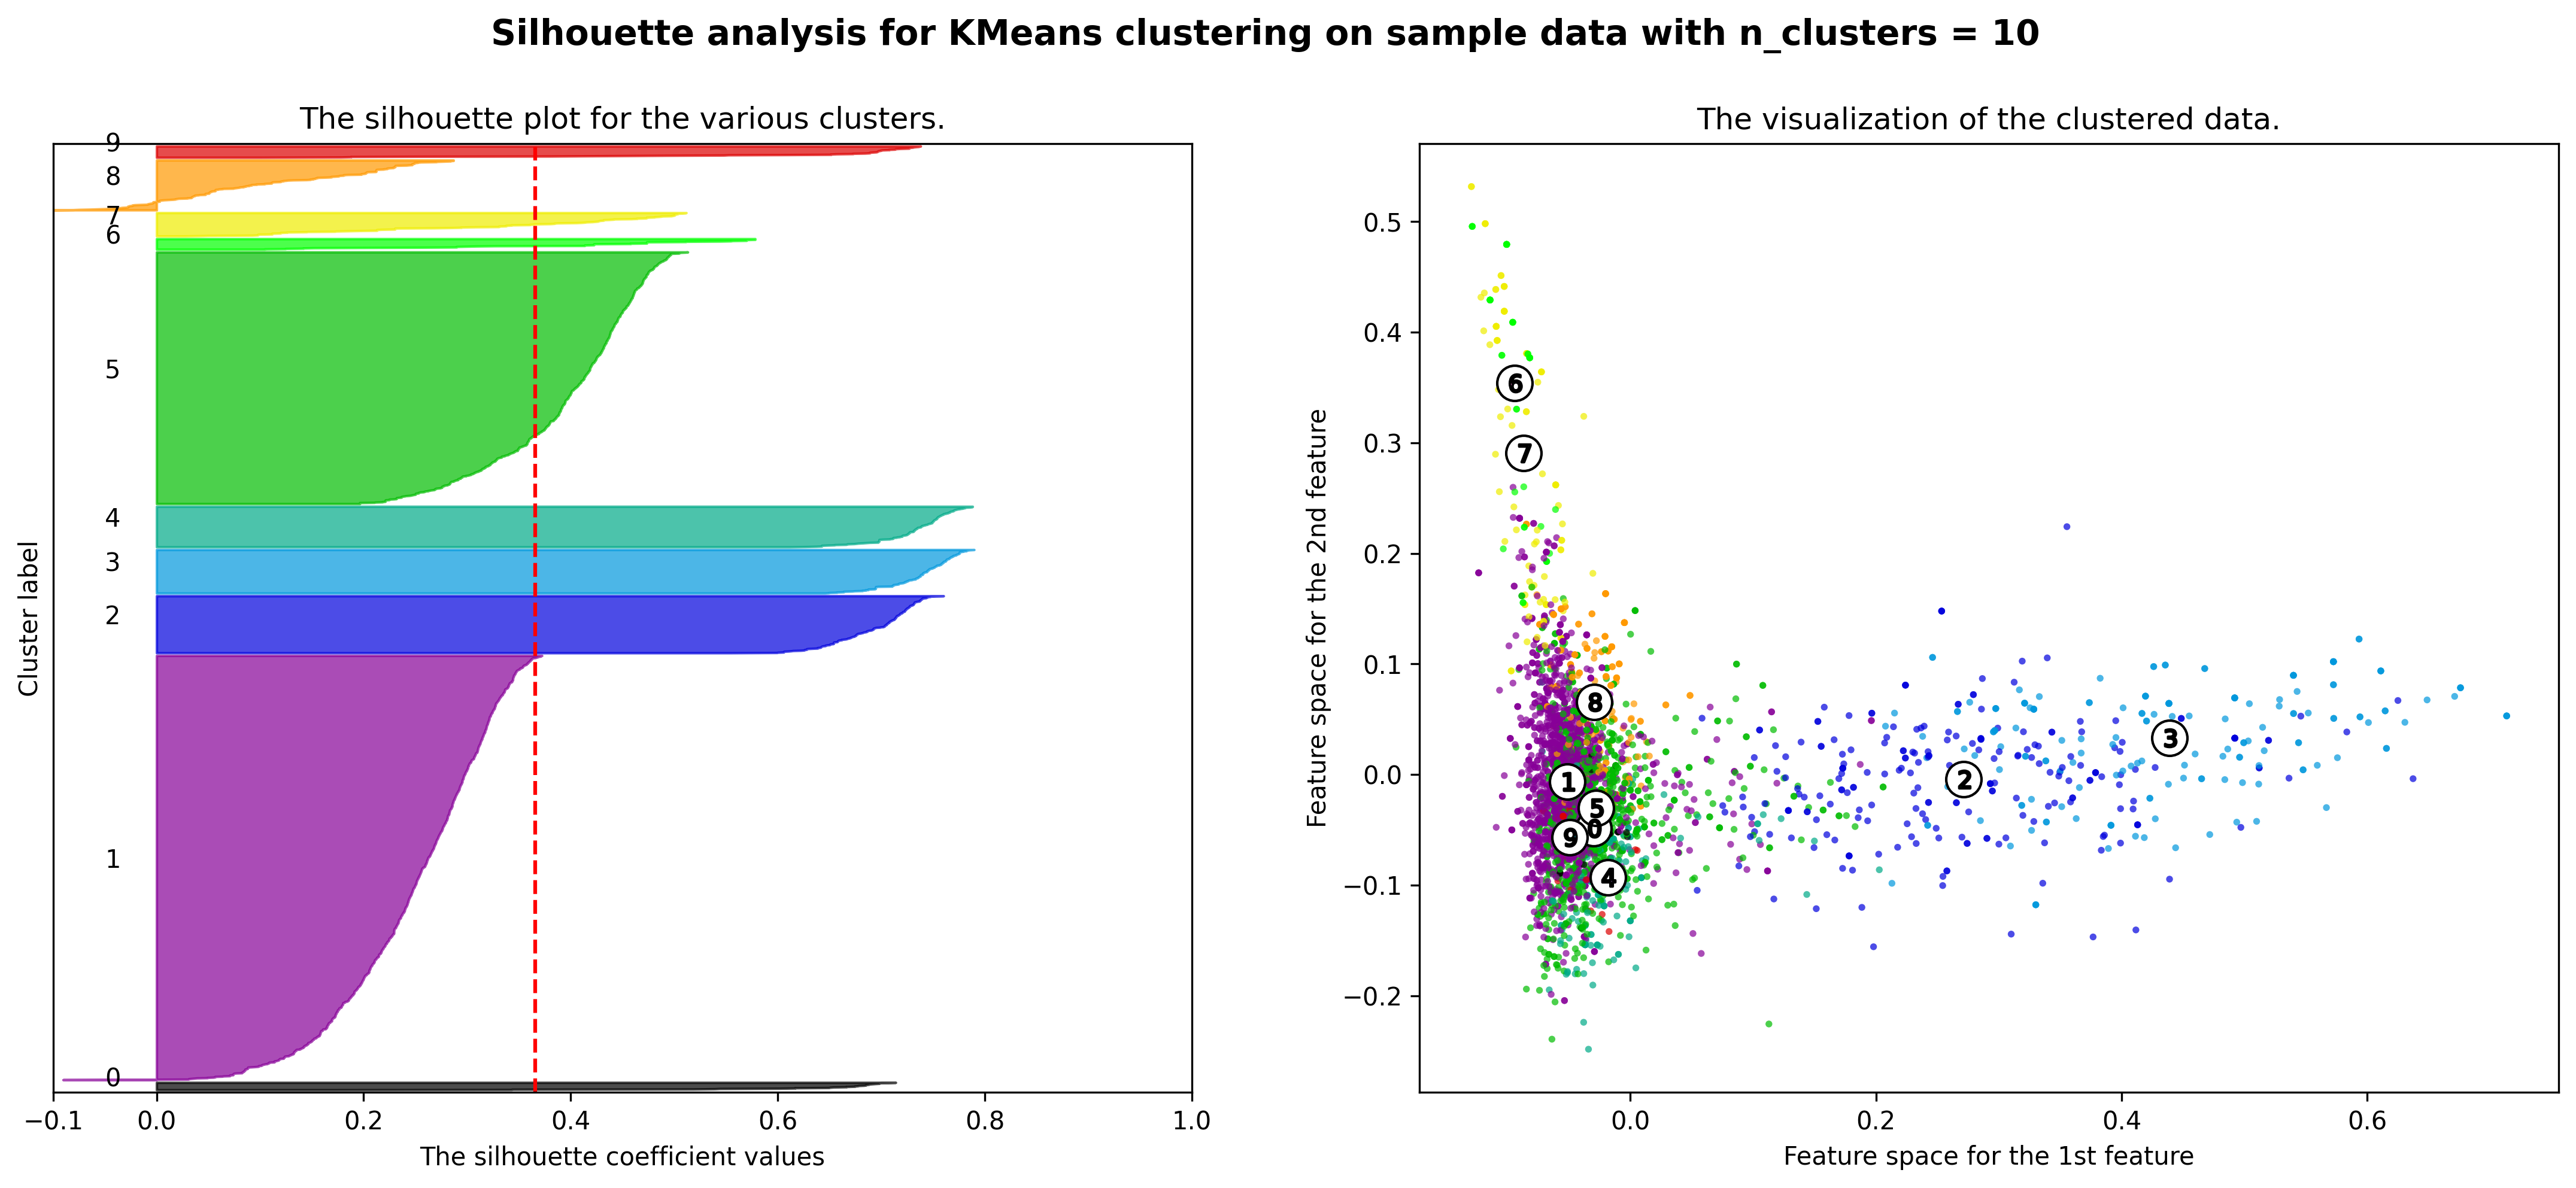

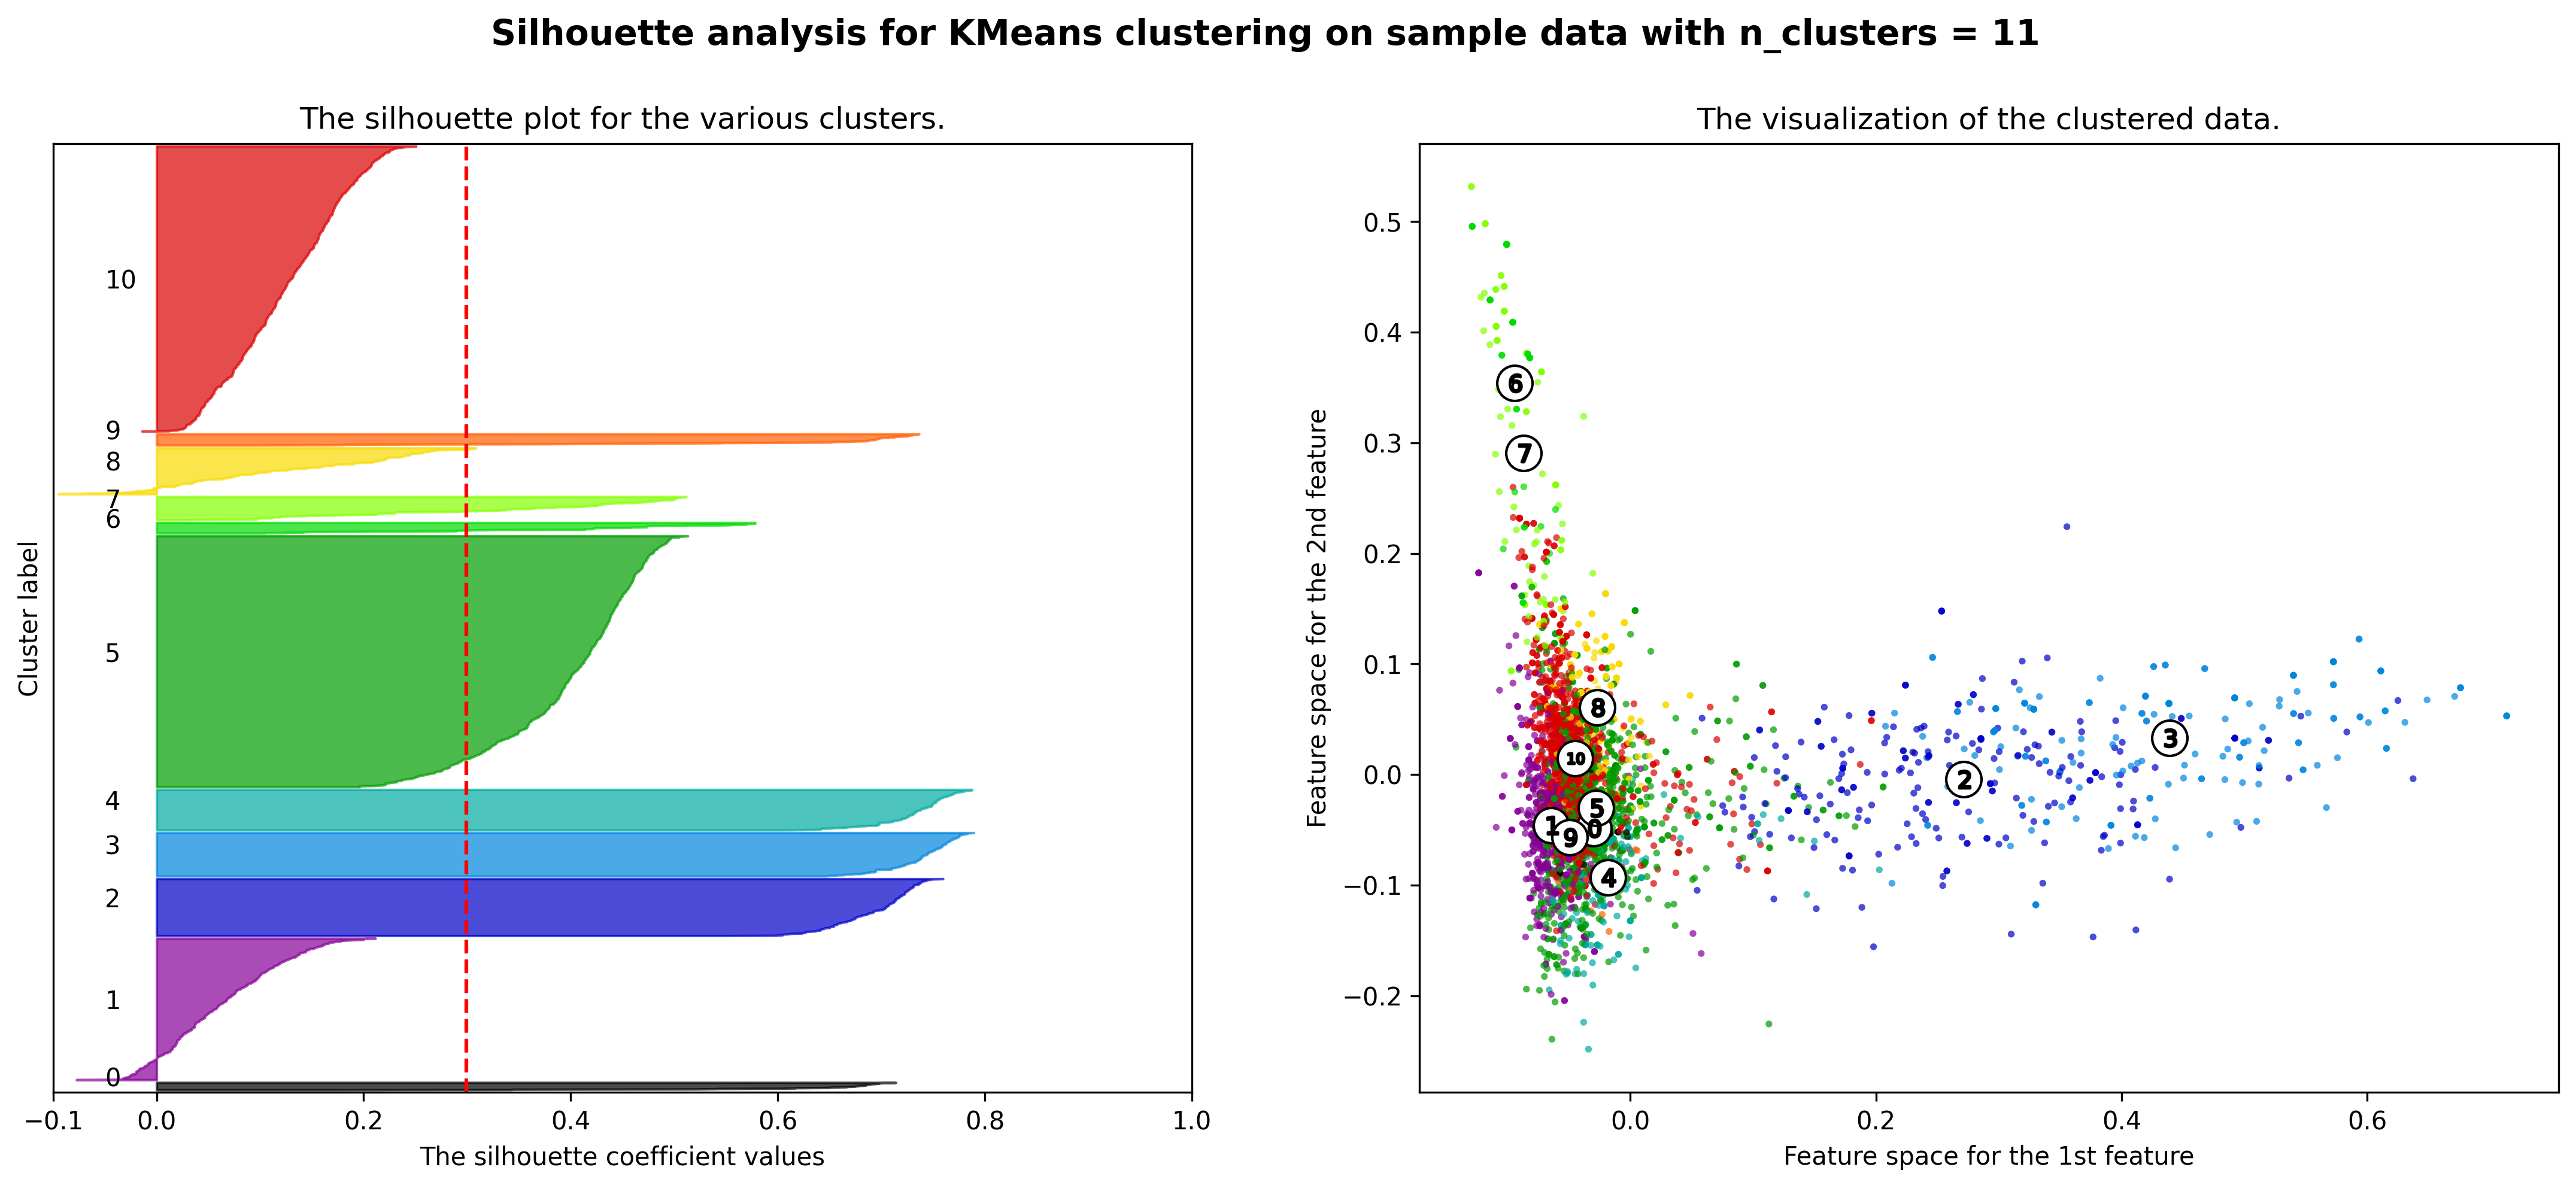

In [0]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

print(__doc__)

# y_lower = 10?
X=X2
y=newfeature
range_n_clusters = [ 3, 4, 5, 6,7,8,9,10,11] # [3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Automatically created module for IPython interactive environment
# For n_clusters = 3 The average silhouette_score is : 0.5939777837442805
# For n_clusters = 4 The average silhouette_score is : 0.6513881381601975
# For n_clusters = 5 The average silhouette_score is : 0.6941849342311135
# For n_clusters = 6 The average silhouette_score is : 0.7397344560527621
# For n_clusters = 7 The average silhouette_score is : 0.712839601569931
# For n_clusters = 8 The average silhouette_score is : 0.34747211935487715
# For n_clusters = 9 The average silhouette_score is : 0.2328580236751874
# For n_clusters = 10 The average silhouette_score is : 0.22561125331217896
# For n_clusters = 11 The average silhouette_score is : 0.24769294313548823

## Vectorize the abstracts using Universal Sentence Encoder

In [0]:
data1 = np.array(df2.abstract.drop_duplicates(keep='last'))
data1

array(['ABSTRACTZika Virus (ZIKV) is a causative agent for poor pregnancy outcome and fetal developmental abnormalities, including microcephaly and eye defects. As a result, ZIKV is now a confirmed teratogen. Understanding host-pathogen interactions, specifically cellular perturbations caused by ZIKV, can provide novel therapeutic targets. In order to complete viral replication, viral pathogens control the host cellular machineries and regulate various factors, including long noncoding RNA (lncRNA) genes, at transcriptional levels. The role of lncRNA genes in the pathogenesis of ZIKV-mediated microcephaly and eye defects is currently unknown. To gain additional insights, we focused on profiling the differentially expressed lncRNA genes during ZIKV infection in mammalian cells. For this study, we employed a contemporary clinical Zika viral isolate, PRVABC59, of Asian genotype. We utilized an unbiased RNA sequencing approach to profile the lncRNA transcriptome in ZIKV infected Vero cells

In [0]:
data1.shape


(2829,)

In [0]:
data1list=data1.tolist()

In [0]:
# this chunk only for kaggle kernel
# %%capture
# # Install the latest Tensorflow version.
# #!pip3 install --upgrade tensorflow-gpu
# # Install TF-Hub.
# !pip3 install tensorflow-hub
# #!pip3 install seaborn

In [0]:
# import numpy as np
# import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/3")

In [0]:
embeddings = embed(data1list)["outputs"]

#print(embeddings)

In [0]:
embeddings.shape

TensorShape([2829, 512])

In [0]:
NParray1941papers512vector=np.array(embeddings)
NParray1941papers512vector

array([[-0.01549872,  0.04980402, -0.04248716, ..., -0.05920278,
        -0.03158405, -0.05466389],
       [-0.05373478,  0.05605317, -0.05679339, ..., -0.02999552,
        -0.05764245, -0.06148957],
       [-0.04530637,  0.03210608, -0.02805022, ...,  0.01911136,
        -0.01970787, -0.06535062],
       ...,
       [-0.06050092, -0.04527746, -0.00258602, ...,  0.04889343,
        -0.04621245, -0.01313145],
       [-0.00188606,  0.05619838, -0.03086171, ..., -0.05402054,
         0.0190527 , -0.04868272],
       [ 0.00888268,  0.05505211,  0.04548997, ..., -0.06238353,
        -0.02069671,  0.01072263]], dtype=float32)

In [0]:
testAbstract1=["background enterovirus 71 ev71 is one of the major causative agents of hand foot and mouth disease hfmd which is sometimes associated with severe central nervous system disease in children there is currently no specific medication for ev71 infection quercetin one of the most widely distributed flavonoids in plants has been demonstrated to inhibit various viral infections however investigation of the antiev71 mechanism has not been reported to date methods the antiev71 activity of quercetin was evaluated by phenotype screening determining the cytopathic effect cpe and ev71induced cells apoptosis the effects on ev71 replication were evaluated further by determining virus yield viral rna synthesis and protein expression respectively the mechanism of action against ev71 was determined from the effective stage and timeofaddition assays the possible inhibitory functions of quercetin via viral 2apro 3cpro or 3dpol were tested the interaction between ev71 3cpro and quercetin was predicted and calculated by molecular docking results quercetin inhibited ev71mediated cytopathogenic effects reduced ev71 progeny yields and prevented ev71induced apoptosis with low cytotoxicity investigation of the underlying mechanism of action revealed that quercetin exhibited a preventive effect against ev71 infection and inhibited viral adsorption moreover quercetin mediated its powerful therapeutic effects primarily by blocking the early postattachment stage of viral infection further experiments demonstrated that quercetin potently inhibited the activity of the ev71 protease 3cpro blocking viral replication but not the activity of the protease 2apro or the rna polymerase 3dpol modeling of the molecular binding of the 3cproquercetin complex revealed that quercetin was predicted to insert into the substratebinding pocket of ev71 3cpro blocking substrate recognition and thereby inhibiting ev71 3cpro activity conclusions quercetin can effectively prevent ev71induced cell injury with low toxicity to host cells quercetin may act in more than one way to deter viral infection exhibiting some preventive and a powerful therapeutic effect against ev71 further quercetin potently inhibits ev71 3cpro activity thereby blocking ev71 replication"]

In [0]:
testAbstract2=["background to investigate the effects and immunological mechanisms of the traditional chinese medicine xinjiaxiangruyin on controlling influenza virus fm1 strain infection in mice housed in a hygrothermal environment methods mice were housed in normal and hygrothermal environments and intranasally infected with influenza virus fm1 a highperformance liquid chromatography fingerprint of xinjiaxiangruyin was used to provide an analytical method for quality control realtime quantitative polymerase chain reaction rtqpcr was used to measure messenger rna expression of tolllike receptor 7 tlr7 myeloid differentiation primary response 88 myd88 and nuclear factorkappa b nfb p65 in the tlr7 signaling pathway and virus replication in the lungs western blotting was used to measure the expression levels of tlr7 myd88 and nfb p65 proteins flow cytometry was used to detect the proportion of th17tregulatory cells results xinjiaxiangruyin effectively alleviated lung inflammation in c57bl6 mice in hot and humid environments guizhimahuanggebantang significantly reduced lung inflammation in c57bl6 mice the expression of tlr7 myd88 and nfb p65 mrna in lung tissue of wt mice in the normal environment gzmhgbt group was significantly lower than that in the model group p  005 in wt mice exposed to the hot and humid environment the expression levels of tlr7 myd88 and nfb p65 mrna in the xjxry group were significantly different from those in the virus group the expression levels of tlr7 myd88 and nfb p65 protein in lung tissue of wt mice exposed to the normal environment gzmhgbt group was significantly lower than those in the model group in wt mice exposed to hot and humid environments the expression levels of tlr7 myd88 and nfb p65 protein in xjxry group were significantly different from those in the virus group conclusion guizhimahuanggebantang demonstrated a satisfactory therapeutic effect on mice infected with the influenza a virus fm1 strain in a normal environment and xinjiaxiangruyin demonstrated a clear therapeutic effect in damp and hot environments and may play a protective role against influenza through downregulation of the tlr7 signal pathway"]

In [0]:
Question1=['What are clinical effective therapeutics or drugs for COVID-19?']

In [0]:
Question2=['What are the therapeutic target genes for COVID-19 or coronavirus?']

In [0]:
Question3=['What are the therapeutic targets for COVID-19 or coronavirus ?']

In [0]:
embeddingsT1 = embed(testAbstract1)["outputs"]
embeddingsT2 = embed(testAbstract2)["outputs"]

embeddingsQ1 = embed(Question1)["outputs"]
embeddingsQ2 = embed(Question2)["outputs"]
embeddingsQ3 = embed(Question3)["outputs"]

test1=np.array(embeddingsT1)
test2=np.array(embeddingsT2)

question1=np.array(embeddingsQ1)
question2=np.array(embeddingsQ2)
question3=np.array(embeddingsQ3)

import textwrap

## Examples of recommend similar papers

### Notice the paper find iteself as the most similar papers with cosine similarity score of 1.

In [0]:
result1 = np.sum(NParray1941papers512vector*test1,axis=1)/(np.sqrt(np.sum(NParray1941papers512vector*NParray1941papers512vector,axis=1))*np.sqrt(np.sum(test1*test1)))
maxRows1=result1.argsort()[-10:][::-1]  #https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
print("The indexes for most similar papers are:") 
print(maxRows1)
print("\n")
print("The cosine similarity for top 10 papers are:") 
print(result1[result1.argsort()[-10:][::-1]])
print("\n")
print("For Paper Abstract:\n")
print(textwrap.fill(testAbstract1[0],100))
print("\nWe found the top 10 most similar papers as listed below:\n")
print(df2.abstract.iloc[maxRows1])

The indexes for most similar papers are:
[ 861 2065 1198  924 2232  219 2175 1120  226 2075]


The cosine similarity for top 10 papers are:
[1.0000001  0.80700105 0.7909352  0.7838513  0.7818941  0.7777225
 0.77658147 0.7759898  0.7755653  0.77484983]


For Paper Abstract:

background enterovirus 71 ev71 is one of the major causative agents of hand foot and mouth disease
hfmd which is sometimes associated with severe central nervous system disease in children there is
currently no specific medication for ev71 infection quercetin one of the most widely distributed
flavonoids in plants has been demonstrated to inhibit various viral infections however investigation
of the antiev71 mechanism has not been reported to date methods the antiev71 activity of quercetin
was evaluated by phenotype screening determining the cytopathic effect cpe and ev71induced cells
apoptosis the effects on ev71 replication were evaluated further by determining virus yield viral
rna synthesis and protein expressio

In [0]:
result2 = np.sum(NParray1941papers512vector*test2,axis=1)/(np.sqrt(np.sum(NParray1941papers512vector*NParray1941papers512vector,axis=1))*np.sqrt(np.sum(test2*test2)))
maxRows2=result2.argsort()[-10:][::-1]  #https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
print("The indexes for most similar papers are:") 
print(maxRows2)
print("\n")
print("The cosine similarity for top 10 papers are:") 
print(result2[result2.argsort()[-10:][::-1]])
print("\n")
print("For Paper Abstract:\n")
print(textwrap.fill(testAbstract2[0],100))
print("\nWe found the top 10 most similar papers as listed below:\n")
print(df2.abstract.iloc[maxRows2])

The indexes for most similar papers are:
[1076 1107 1595 2705 1122   16 1813  509  937 2693]


The cosine similarity for top 10 papers are:
[0.9910007  0.74882424 0.7477858  0.7469298  0.73578364 0.73298264
 0.7248724  0.7198976  0.7186326  0.71382856]


For Paper Abstract:

background to investigate the effects and immunological mechanisms of the traditional chinese
medicine xinjiaxiangruyin on controlling influenza virus fm1 strain infection in mice housed in a
hygrothermal environment methods mice were housed in normal and hygrothermal environments and
intranasally infected with influenza virus fm1 a highperformance liquid chromatography fingerprint
of xinjiaxiangruyin was used to provide an analytical method for quality control realtime
quantitative polymerase chain reaction rtqpcr was used to measure messenger rna expression of
tolllike receptor 7 tlr7 myeloid differentiation primary response 88 myd88 and nuclear factorkappa b
nfb p65 in the tlr7 signaling pathway and virus replic

## Example of Question Answering system

In [0]:
resultq1 = np.sum(NParray1941papers512vector*question1,axis=1)/(np.sqrt(np.sum(NParray1941papers512vector*NParray1941papers512vector,axis=1))*np.sqrt(np.sum(question1*question1)))
maxRowsq1=resultq1.argsort()[-20:][::-1]  #https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
print("The indexes for most related papers are:") 
print(maxRowsq1)
print("\n")
print("The cosine similarity for top 20 papers are:") 
print(resultq1[resultq1.argsort()[-20:][::-1]])
print("\n")
print("For Question:\n")
print(textwrap.fill(Question1[0],100))
print("\nWe found the top 20 most related papers as listed below:\n")
print(df2.abstract.iloc[maxRowsq1])

The indexes for most related papers are:
[2290 1848   52 1473  786 2583  123 1028 2103 1564 2348 2775 2703  307
 2201   24 2421 1953 1991  705]


The cosine similarity for top 20 papers are:
[0.40659484 0.3843246  0.3743309  0.35291278 0.34027264 0.3185312
 0.31485572 0.30598685 0.30495515 0.30156365 0.29851666 0.29495987
 0.29464674 0.2941549  0.2931563  0.29151216 0.29062632 0.28947386
 0.2864972  0.28554276]


For Question:

What are clinical effective therapeutics or drugs for COVID-19?

We found the top 20 most related papers as listed below:

2310    A key barrier against developing preventive an...
1864    All coronaviruses, including the recently emer...
52      Abstract17 years after the SARS-CoV epidemic, ...
1482    Zika virus (ZIKV) is a global public health is...
795     BACKGROUND: Respiratory syncytial virus (RSV) ...
2607    Abstract Pharyngitis, bronchitis, and pneumoni...
123     Last December 2019, a new virus, named COVID-2...
1037    Oligonucleotides are key elemen

In [0]:
TherapeutAbstractmostRelatedQ1=df2.abstract.iloc[maxRowsq1]

In [0]:
DFTherapeutAbstractmostRelatedQ1=pd.DataFrame(TherapeutAbstractmostRelatedQ1)

In [0]:
DFTherapeutAbstractmostRelatedQ1

abstract
2310  A key barrier against developing preventive an...
1864  All coronaviruses, including the recently emer...
52    Abstract17 years after the SARS-CoV epidemic, ...
1482  Zika virus (ZIKV) is a global public health is...
795   BACKGROUND: Respiratory syncytial virus (RSV) ...
2607  Abstract Pharyngitis, bronchitis, and pneumoni...
123   Last December 2019, a new virus, named COVID-2...
1037  Oligonucleotides are key elements of nucleic a...
2121  Following intracranial infection with the neur...
1573  Pulmonary viral infections are associated with...
2368  [Purpose] Multi-drug resistant (MDR), Mycobact...
2799  Abstract RNAi has rapidly become a powerful to...
2727  Abstract Here, we review the current knowledge...
309   The synthesis of inactive enzyme precursors, a...
2219  In the majority of potential applications gene...
24    AbstractThe outbreak of a novel betacoronaviru...
2443  The recently emerged severe acute respiratory ...
1970  Numerous pathological states including cancer,...
2008  OBJECTIVE: Immune-related abnormalities are co...
713   BACKGROUND: The dominant viral etiologies resp...

In [0]:
DFTherapeutAbstractmostRelatedQ1.to_csv(data_path+"TherapeutAbstractmostRelatedQ1.csv", sep=',',index=False)

In [0]:
resultq2 = np.sum(NParray1941papers512vector*question2,axis=1)/(np.sqrt(np.sum(NParray1941papers512vector*NParray1941papers512vector,axis=1))*np.sqrt(np.sum(question2*question2)))
maxRowsq2=resultq2.argsort()[-50:][::-1]  #https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
print("The indexes for most related papers are:") 
print(maxRowsq2)
print("\n")
print("The cosine similarity for top 50 papers are:") 
print(resultq2[resultq2.argsort()[-50:][::-1]])
print("\n")
print("For Question:\n")
print(textwrap.fill(Question2[0],100))
print("\nWe found the top 50 most related papers as listed below:\n")
print(df2.abstract.iloc[maxRowsq2])

The indexes for most related papers are:
[ 541 1147 2513  325  935 1772 2534 1468 1990 2687 1955 2132 1840 2047
  283  206 2362 2519 1796  238 1379 1236 1867 2720  826  830 2737 2779
 2451 2004 1564   33  615 1421 2264 2709 2256 1291 1310 1492 2430 1984
  941 2065 2704  860 1657 2214   85 2802]


The cosine similarity for top 50 papers are:
[0.3799323  0.37921083 0.34123394 0.3394444  0.33837473 0.32322025
 0.32219538 0.31820408 0.31675103 0.31634915 0.3116745  0.3099891
 0.3094792  0.3090218  0.30731162 0.3051798  0.30357796 0.30338457
 0.3026685  0.30171657 0.3013029  0.3010628  0.29594082 0.29553592
 0.29510602 0.2923498  0.29216102 0.29040483 0.28877017 0.28805986
 0.28797722 0.28755173 0.2875167  0.28666702 0.28603497 0.28478888
 0.2829116  0.28236866 0.281067   0.2799464  0.27921033 0.27910417
 0.27822247 0.27792537 0.27756074 0.277108   0.2753145  0.27459642
 0.27407888 0.27403852]


For Question:

What are the therapeutic target genes for COVID-19 or coronavirus?

We found the 

In [0]:
TherapeutAbstractmostRelatedQ2=df2.abstract.iloc[maxRowsq2]

In [0]:
DFTherapeutAbstractmostRelatedQ2=pd.DataFrame(TherapeutAbstractmostRelatedQ2)
DFTherapeutAbstractmostRelatedQ2

abstract
549   The renin-angiotensin-system (RAS) constitutes...
1156  Cyclooxygenases (COXs)/prostaglandin E(2) (PGE...
2537  Human enterovirus 71 (HEV71) is the cause of h...
327   BACKGROUND: Antibodies constitute a powerful t...
944   Viral hepatitis, as an international public he...
1785  A virus initiates infection by attaching to it...
2558  Viral protease inhibitors are remarkably effec...
1477  Peptides are secreted by different cell types ...
2007  Dicer-substrate siRNAs equipped with CpG oligo...
2711  Publisher Summary This chapter discusses respi...
1972  The 2014–2015 outbreak of Ebola virus disease ...
2150  Rotaviruses and orbiviruses are nonturreted Re...
1856  Computational analyses of genome sequences may...
2064  Chikungunya virus (CHIKV) is a medically impor...
285   Blood is the pipeline of the immune system. As...
208   BACKGROUND: Acute respiratory illnesses (ARIs)...
2382  Screening of chemical libraries with 2,000 syn...
2543  Antiviral therapies that impede virus entry ar...
1810  The woodchuck hepatitis virus (WHV) and its ho...
240   Mammalian cells are the expression system of c...
1388  The Zika virus (ZIKV) outbreak and its link to...
1245  In many countries, vaccines are used for the p...
1883  Plants are able to perform post-translational ...
2744  Abstract The ability to rapidly and reliably d...
835   Acute viral infections pose many practical cha...
839   Hantaviruses can cause hantavirus pulmonary sy...
2761  Abstract We present a case of disseminated aty...
2803  Publisher Summary This chapter focuses on non-...
2473  Influenza A virus (IAV), a major cause of huma...
2021  Highly pathogenic porcine reproductive and res...
1573  Pulmonary viral infections are associated with...
33    SUMMARYA new coronavirus (CoV) identified as C...
623   BACKGROUND: Porcine circovirus type 2 (PCV2) i...
1430  ABSTRACT: Excessive activities of cysteinyl ca...
2284  Due to their low immunogenicity in patients, h...
2733  Abstract The innate immune system forms our fi...
2276  The functional role of IL-12 and IL-23 in host...
1300  Middle East respiratory syndrome (MERS) corona...
1319  Autophagy is a homeostatic mechanism that disc...
1501  Ribonucleases (RNases) are a large number of e...
2452  The angiotensin converting enzyme 2/angiotensi...
2001  Standard therapies used for the treatment of A...
950   Although, after an epidemic of over 28 000 cas...
2082  Porcine epidemic diarrhea virus (PEDV) causes ...
2728  Abstract The filamentous fungus Penicillium ch...
869   A major hallmark of the autoimmune demyelinati...
1666  The filoviruses, Ebola virus (EBOV), and Marbu...
2232  West Nile virus and dengue virus are mosquito-...
85    AbstractSevere fever with thrombocytopenia syn...
2826  Abstract Polysaccharides play multiple roles a...

In [0]:
DFTherapeutAbstractmostRelatedQ2.to_csv(data_path+"TherapeutAbstractmostRelatedQ2.csv", sep=',',index=False)

In [0]:
# looking at DFTherapeutWINDOWmostRelatedQ2, WINDOW level does not need to T5 summary. for Q1, T5 summary from 30 words window did not yield good results. see the other notebook.
# conclusion: still better work on abs level.

In [0]:
resultq3 = np.sum(NParray1941papers512vector*question3,axis=1)/(np.sqrt(np.sum(NParray1941papers512vector*NParray1941papers512vector,axis=1))*np.sqrt(np.sum(question3*question3)))
maxRowsq3=resultq3.argsort()[-20:][::-1]  #https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
print("The indexes for most related papers are:") 
print(maxRowsq3)
print("\n")
print("The cosine similarity for top 20 papers are:") 
print(resultq3[resultq3.argsort()[-20:][::-1]])
print("\n")
print("For Question:\n")
print(textwrap.fill(Question3[0],100))
print("\nWe found the top 20 most related papers as listed below:\n")
print(df2.abstract.iloc[maxRowsq3])

The indexes for most related papers are:
[ 541 1955  935 1468  860 2630  830   52  480 1840 2513  213 1867 2290
 1973 2709 2264 2004 2421 1822]


The cosine similarity for top 20 papers are:
[0.36582395 0.30675077 0.30000713 0.28893185 0.27774763 0.26476076
 0.26086327 0.25461808 0.24995624 0.24878134 0.24873856 0.24721733
 0.2449917  0.2423241  0.24099244 0.24003708 0.23609552 0.23598842
 0.23557164 0.23295021]


For Question:

What are the therapeutic targets for COVID-19 or coronavirus ?

We found the top 20 most related papers as listed below:

549     The renin-angiotensin-system (RAS) constitutes...
1972    The 2014–2015 outbreak of Ebola virus disease ...
944     Viral hepatitis, as an international public he...
1477    Peptides are secreted by different cell types ...
869     A major hallmark of the autoimmune demyelinati...
2654    Abstract Imbalance or malfunction of the immun...
839     Hantaviruses can cause hantavirus pulmonary sy...
52      Abstract17 years after the SARS